In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


## Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,accuracy_score,mean_squared_error,precision_score,recall_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from catboost import CatBoostClassifier as CBC

lb = LabelEncoder() 
plt.rcParams['figure.figsize'] = (20,8)
pd.options.display.max_columns = 100

### Function to read data

In [3]:
def read_data(locations):
    if locations == None:
        print('Please enter a valid Location for the data')
        return 0
    elif str.find(locations,'.csv') >=0:
        return pd.read_csv(locations,error_bad_lines=False)
        
    elif str.find(locations,'.xlsx') >=0:
        return pd.read_excel(locations,error_bad_lines= False)
    else:
        print('Data type not supported')
        return 0

### Function to remove nan from data

In [4]:
def remove_nan(data, indexes):
    for i in indexes:
        data.loc[np.isnan(data[i]),i] = np.nanmedian(data[i])
    return data

### Function to detect numeric data attribute within a dataset

In [5]:
def detect_numerals(data):
    num = data.dtypes.index[(data.dtypes == 'int64')| (data.dtypes == 'int32')|(data.dtypes == 'float64')].tolist()
    if len(data.isnull().sum()[data.isnull().sum() > 0].index.tolist()) > 0:
        indexes = data.isnull().sum()[data.isnull().sum() > 0].index.tolist()
        data = remove_nan(data,indexes)
    non_num = list()
    for i in num:
        if np.unique(data[i]).shape[0] <= 10:
            non_num.append(i)
        
    return set(num) - set(non_num),data

### Function to plot important features

In [6]:
def plot_imp_feat(cols, feat_imp):
    '''
    col = Column names used to predict the label
    feat_imp = Model feature importance data or matrix
    This function plots the feature importance of the dataset's attributes.
    '''
    feat = pd.DataFrame()
    feat['features'] = cols
    feat['importance'] = feat_imp
    feat = feat.sort_values(by = 'importance')
    
    plt.barh(feat.features,feat.importance)

### Encoding variables

In [7]:
def convert(df, columns):
    for i in columns:
        df[i] = lb.fit_transform(df[i])
    return df

### Function for submission

In [8]:
def make_submission(ids,preds,col_names,name = 'submission.csv'):
    '''
    ids = id column of submission dataset
    preds = predictions made by the model
    col_names = A list of length 2 which consists the column names of submission file
    name = Name of the submission file
    '''
    if len(ids) != len(preds):
        raise ValueError('Ids and predictions lengths are not same')
        
    submission = pd.DataFrame()
    submission[col_names[0]] = ids
    submission[col_names[1]] = preds

    submission.to_csv(f'./{name}', index = False)

## Reading the data 

In [9]:
train_set = read_data('./Datasets/Analytics Vidhya Datafest Supremacy/train.csv')
test_set = read_data('./Datasets/Analytics Vidhya Datafest Supremacy/test.csv')

train_set.columns= ['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'enrolled_university_1',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target']
test_set.columns = ['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'enrolled_university_1',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours']

## Analysis of Data

In [215]:
train_set.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,enrolled_university_1,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [216]:
train_set.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4098
relevent_experience          0
enrolled_university        342
enrolled_university_1      457
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

In [18]:
#convert experience to numeric
train_set.loc[train_set.experience == '>20', 'experience'] = '21'
train_set.loc[train_set.experience == '<1', 'experience'] = '0'
train_set.experience = pd.to_numeric(train_set.experience)

test_set.loc[test_set.experience == '>20', 'experience'] = '21'
test_set.loc[test_set.experience == '<1', 'experience'] = '0'
test_set.experience = pd.to_numeric(test_set.experience)


In [19]:
train_set.loc[train_set.experience.isnull(), 'experience'] = int(np.nanmean(train_set.experience))
test_set.loc[test_set.experience.isnull(), 'experience'] = int(np.nanmean(test_set.experience))

In [20]:
#convert last_new_job to numeric
train_set.loc[train_set.last_new_job == '>4', 'last_new_job'] = '5'
train_set.loc[train_set.last_new_job == 'never', 'last_new_job'] = '0'
train_set.last_new_job = pd.to_numeric(train_set.last_new_job)


test_set.loc[test_set.last_new_job == '>4', 'last_new_job'] = '5'
test_set.loc[test_set.last_new_job == 'never', 'last_new_job'] = '0'
test_set.last_new_job = pd.to_numeric(test_set.last_new_job)


### Extracting trends from data

On what attribute target label depends?

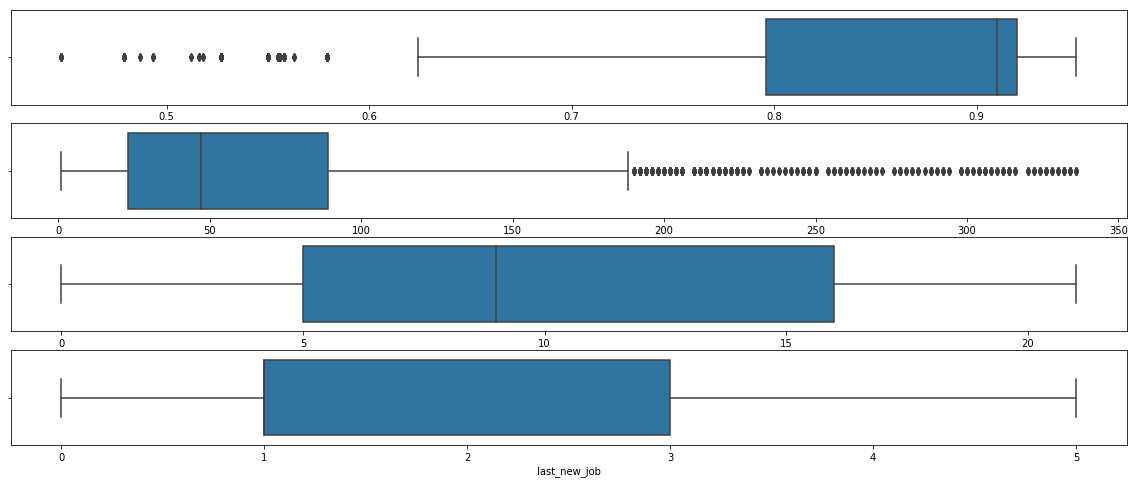

In [291]:
f,ax = plt.subplots(nrows = 4)
sns.boxplot(train_set.city_development_index, ax = ax[0])
sns.boxplot(train_set.training_hours, ax = ax[1])
sns.boxplot(train_set.experience, ax = ax[2])
sns.boxplot(train_set.last_new_job, ax = ax[3])

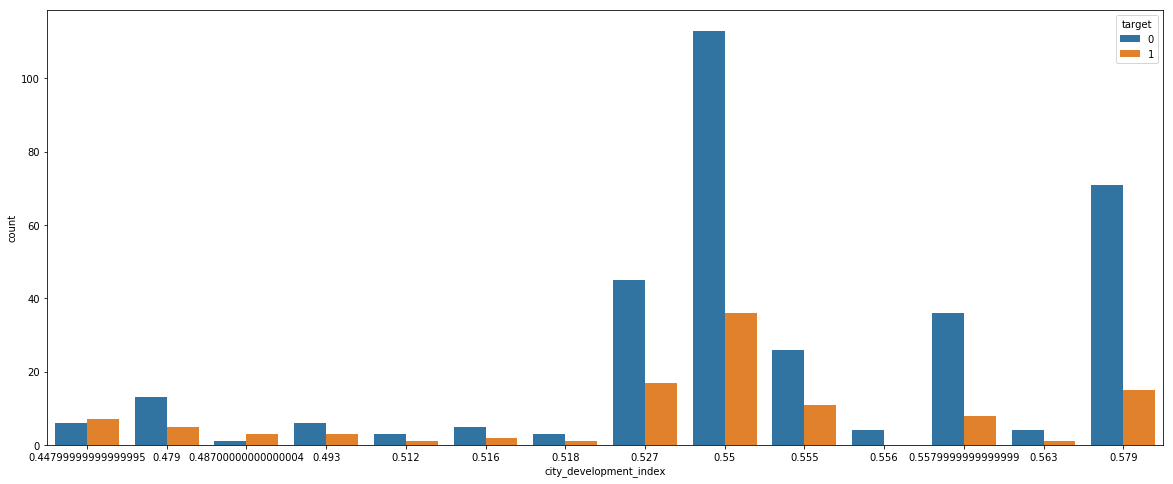

In [303]:
# sns.countplot('training_hours', hue = 'target',data = train_set[train_set.training_hours > 200])
sns.countplot('city_development_index', hue = 'target',data = train_set[train_set.city_development_index < 0.6])

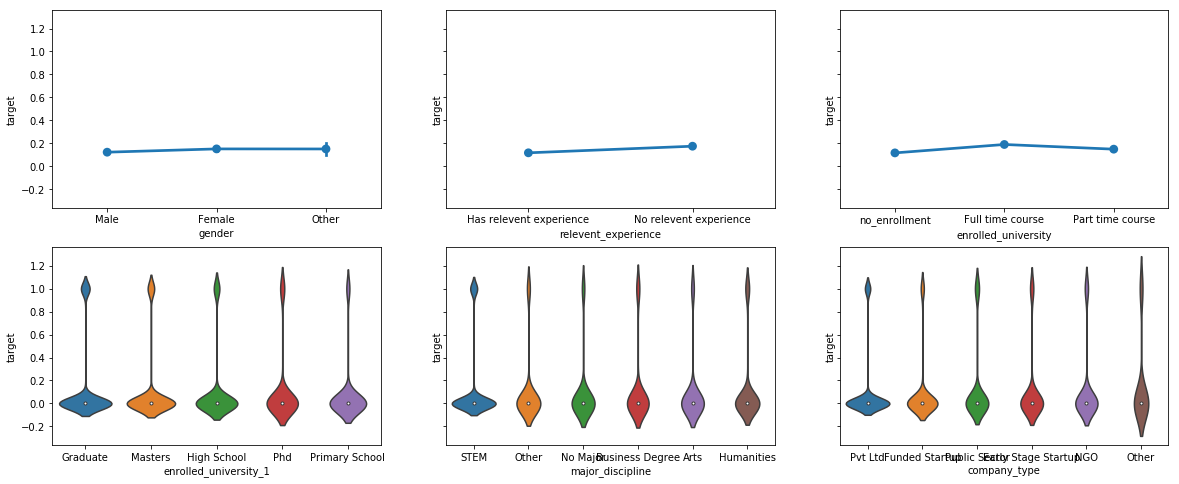

In [55]:
f,axes = plt.subplots(2,3,sharey = True)
for i,j in zip(['gender','relevent_experience','enrolled_university'],range(3)):
    sns.pointplot(x=i,y = 'target', data = train_set, ax = axes[0][j])

for i,j in zip(['enrolled_university_1','major_discipline','company_type'],range(3)):
    sns.violinplot(x=i,y = 'target', data = train_set, ax = axes[1][j])


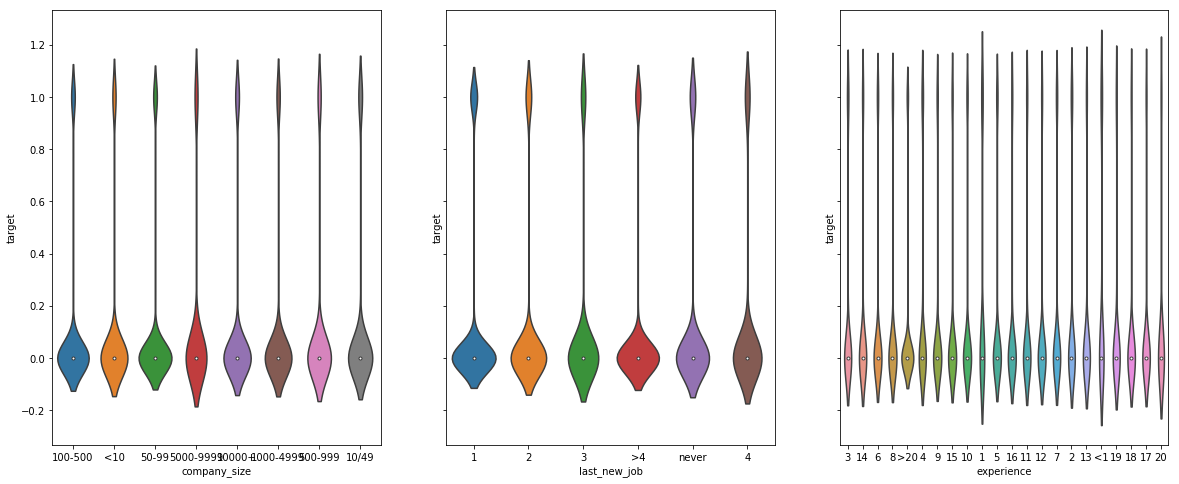

In [61]:
f,axes = plt.subplots(1,3,sharey=True)
for i,j in zip(['company_size','last_new_job','experience'],range(3)):
    sns.violinplot(x=i,y = 'target', data = train_set, ax = axes[j])

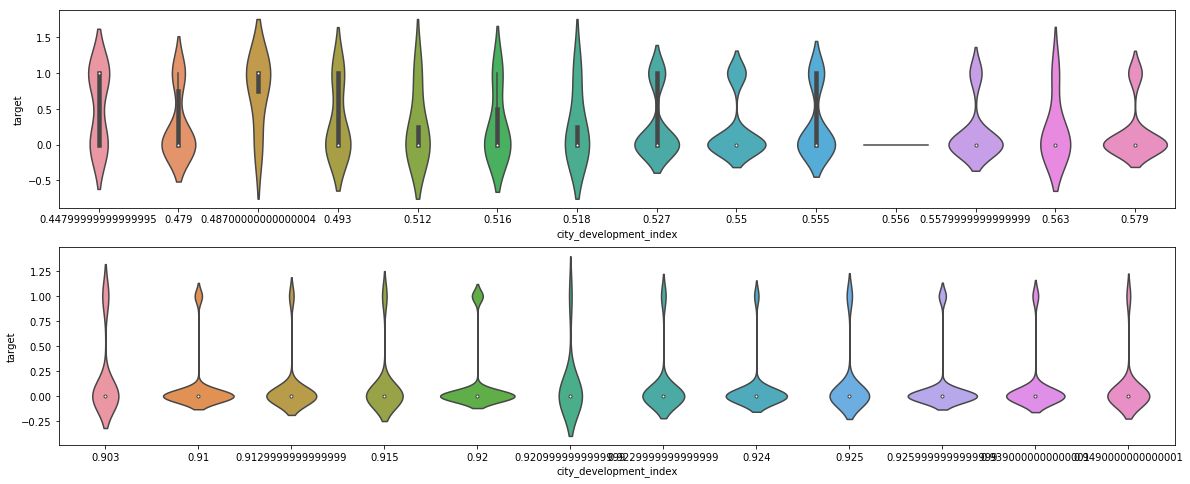

In [37]:
plt.subplot(211)
sns.violinplot('city_development_index','target',data = train_set[train_set.city_development_index < 0.60])
plt.subplot(212)
sns.violinplot('city_development_index','target',data = train_set[train_set.city_development_index > 0.90])

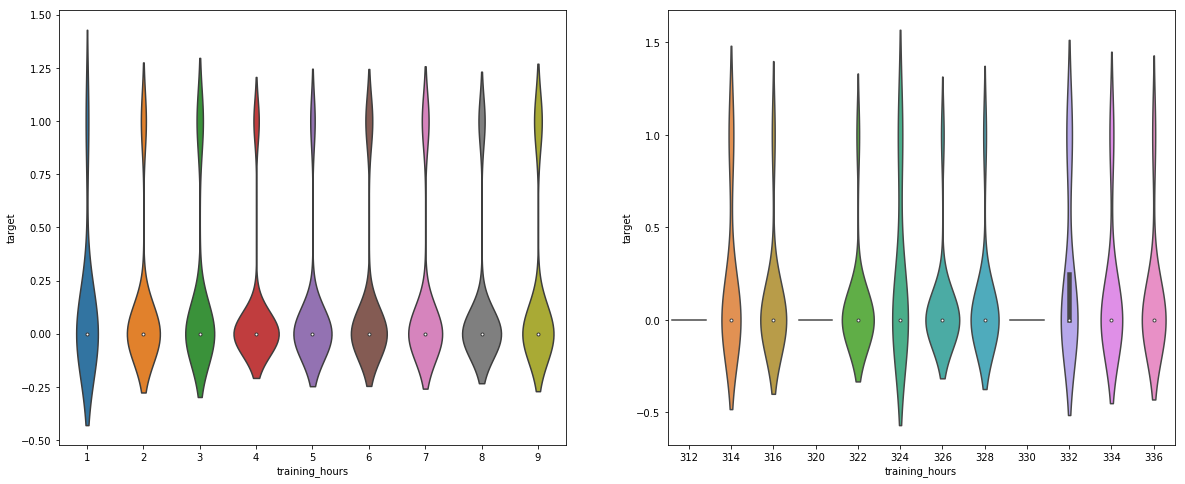

In [46]:
plt.subplot(121)
sns.violinplot('training_hours','target', data = train_set[train_set.training_hours < 10])
plt.subplot(122)
sns.violinplot('training_hours','target', data = train_set[train_set.training_hours > 310])


In [ ]:
sns.boxplot()

### Analysis for attributes which have missing data

#### Gender

C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


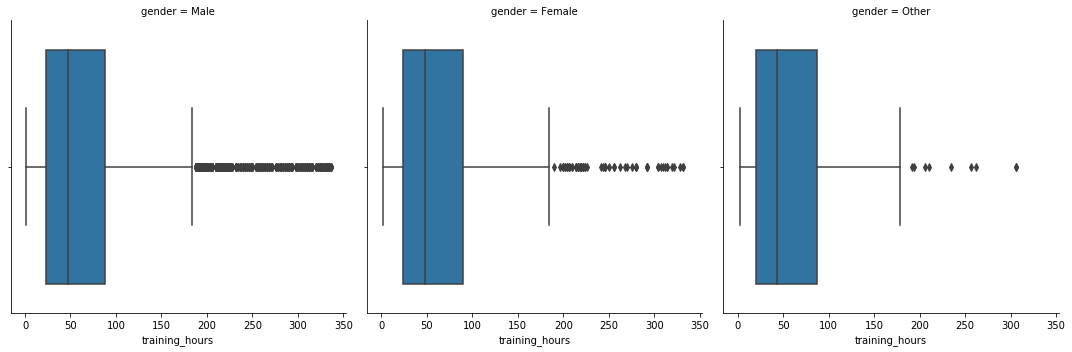

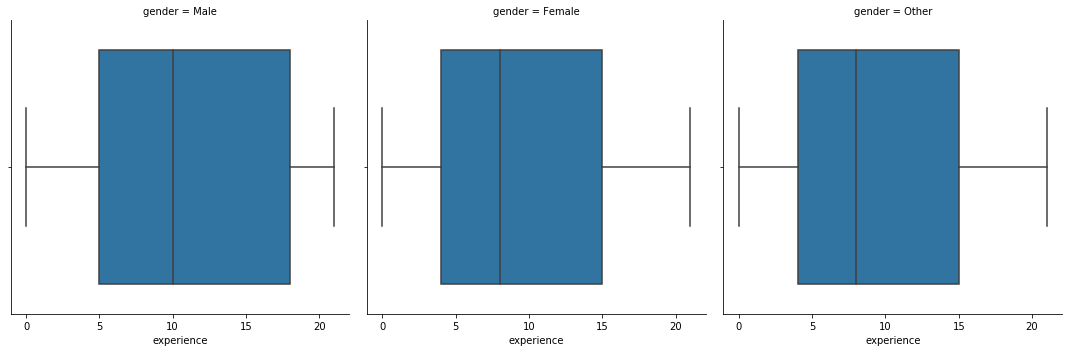

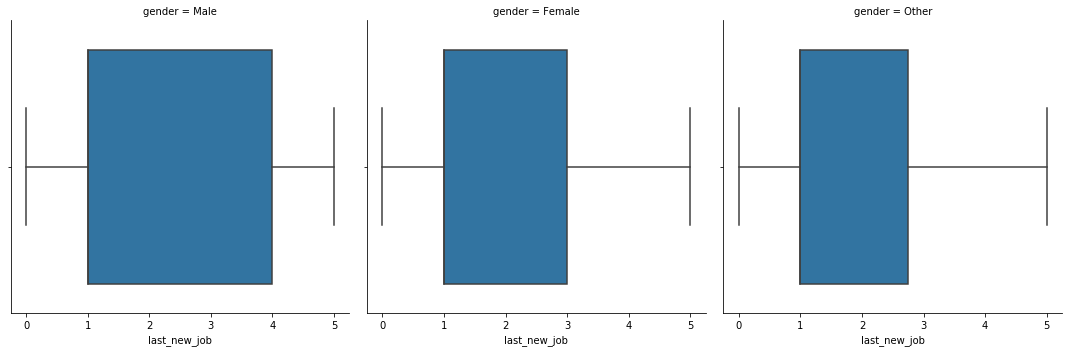

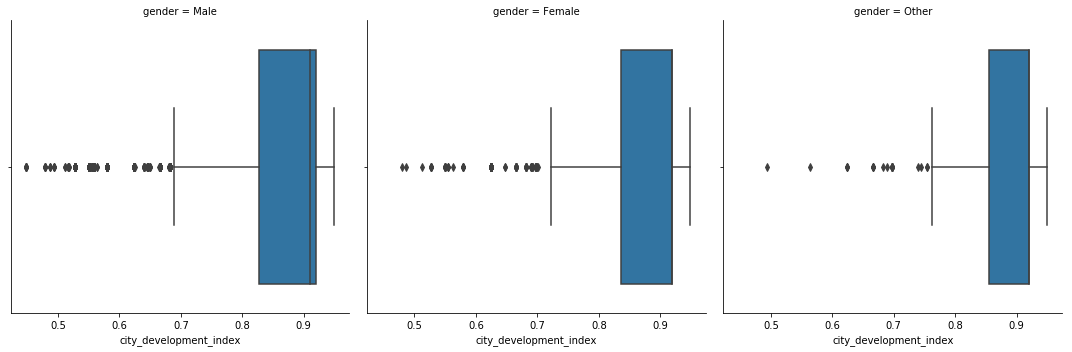

In [135]:
g = sns.FacetGrid(data = train_set, col = 'gender',size = 5)
g.map(sns.boxplot, 'training_hours')

g = sns.FacetGrid(data = train_set, col = 'gender',size = 5)
g.map(sns.boxplot, 'experience')

g = sns.FacetGrid(data = train_set, col = 'gender',size = 5)
g.map(sns.boxplot, 'last_new_job')

g = sns.FacetGrid(data = train_set, col = 'gender',size = 5)
g.map(sns.boxplot, 'city_development_index')

[Graduate          7691
 Masters           2987
 High School       1420
 Phd                311
 Primary School     215
 Name: enrolled_university_1, dtype: int64,
 Series([], Name: enrolled_university_1, dtype: int64),
 Graduate          734
 Masters           320
 High School        65
 Phd                53
 Primary School      5
 Name: enrolled_university_1, dtype: int64,
 Graduate          109
 High School        34
 Masters            26
 Primary School      7
 Phd                 3
 Name: enrolled_university_1, dtype: int64]

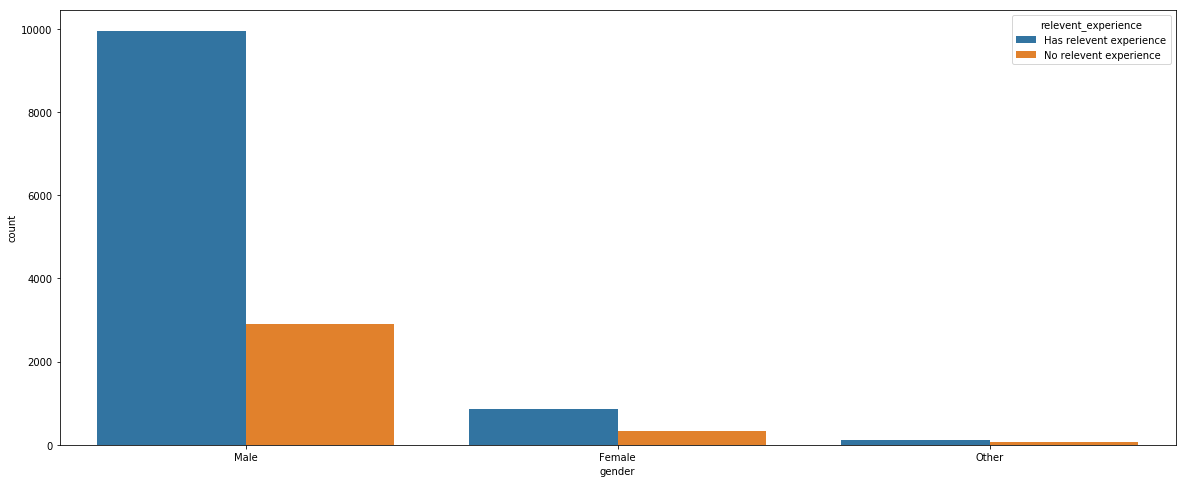

In [141]:
# sns.violinplot(y='city_development_index',x='gender', data =train_set)
sns.countplot(x = 'gender',hue = 'relevent_experience',data = train_set)
[pd.value_counts(train_set[train_set.gender == i].enrolled_university) for i in train_set.gender.unique()]
[pd.value_counts(train_set[train_set.gender== i].enrolled_university_1) for i in train_set.gender.unique()]

* <strong>For gender:  important attributes are city_development_index , last_new_job, experience </strong>

#### Enrolled University

C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


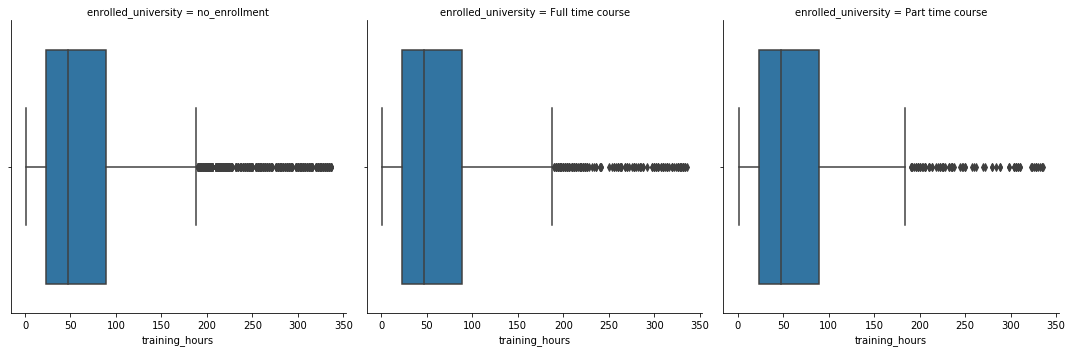

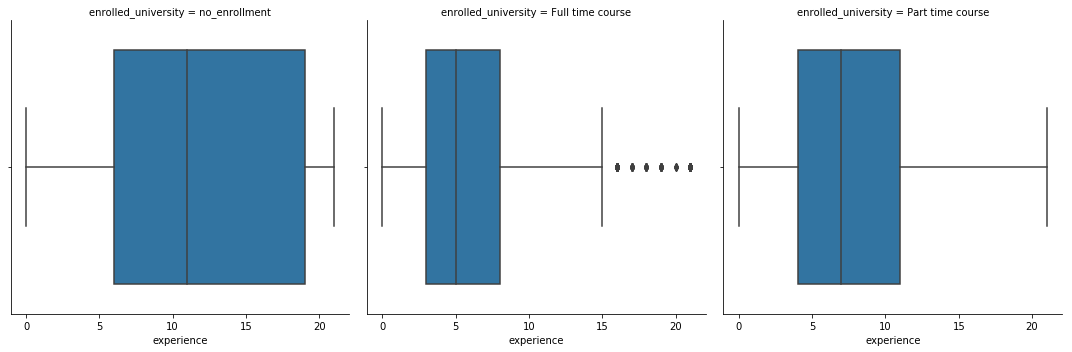

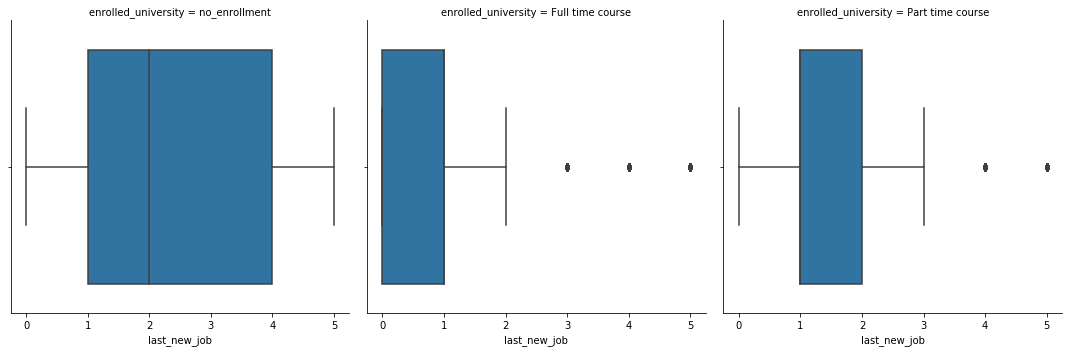

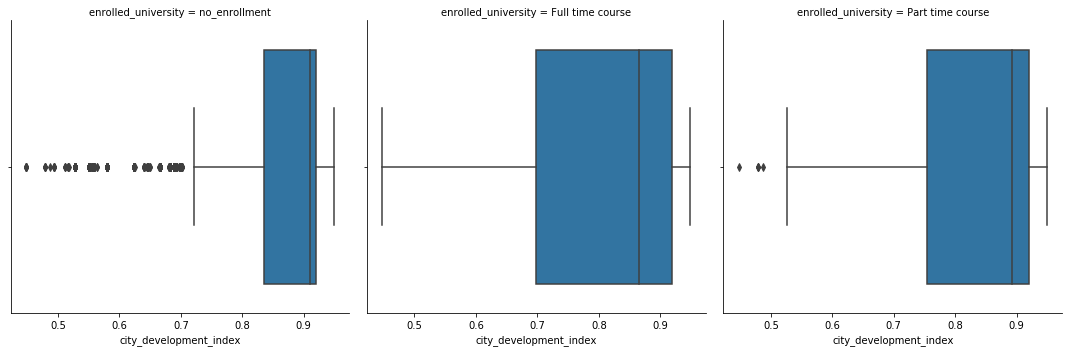

In [136]:
g = sns.FacetGrid(data = train_set, col = 'enrolled_university',size = 5)
g.map(sns.boxplot, 'training_hours')

g = sns.FacetGrid(data = train_set, col = 'enrolled_university',size = 5)
g.map(sns.boxplot, 'experience')

g = sns.FacetGrid(data = train_set, col = 'enrolled_university',size = 5)
g.map(sns.boxplot, 'last_new_job')

g = sns.FacetGrid(data = train_set, col = 'enrolled_university',size = 5)
g.map(sns.boxplot, 'city_development_index')

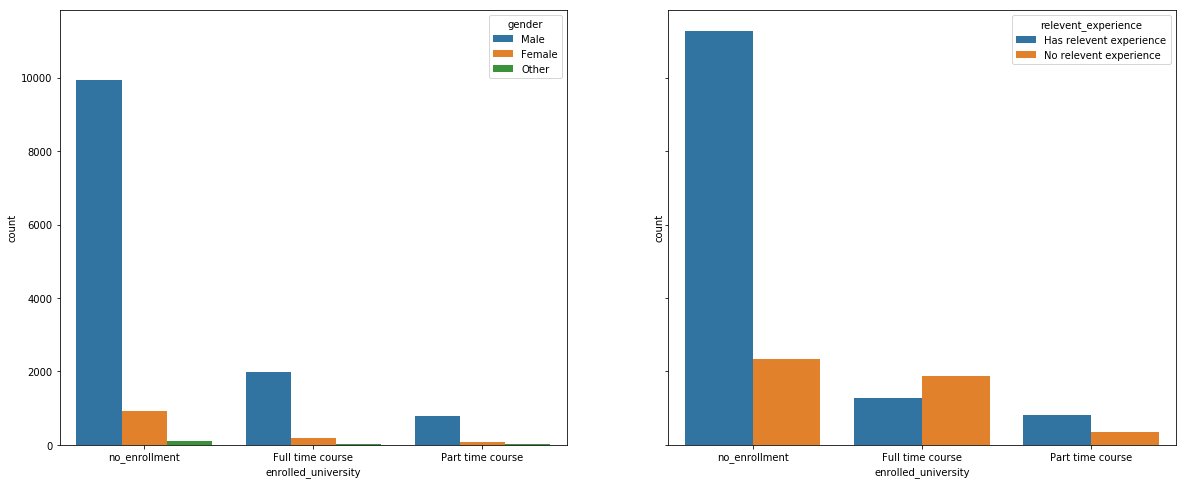

In [140]:
f, ax = plt.subplots(ncols = 2, sharey = True)
sns.countplot(x = 'enrolled_university',hue = 'gender',data = train_set,ax = ax[0])
sns.countplot(x = 'enrolled_university',hue = 'relevent_experience',data = train_set,ax = ax[1])

* <strong> For enrolled_university: important attributes are city_development_index, relevent_experience, last_new_job, experience </strong>

#### Enrolled_university_1

C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


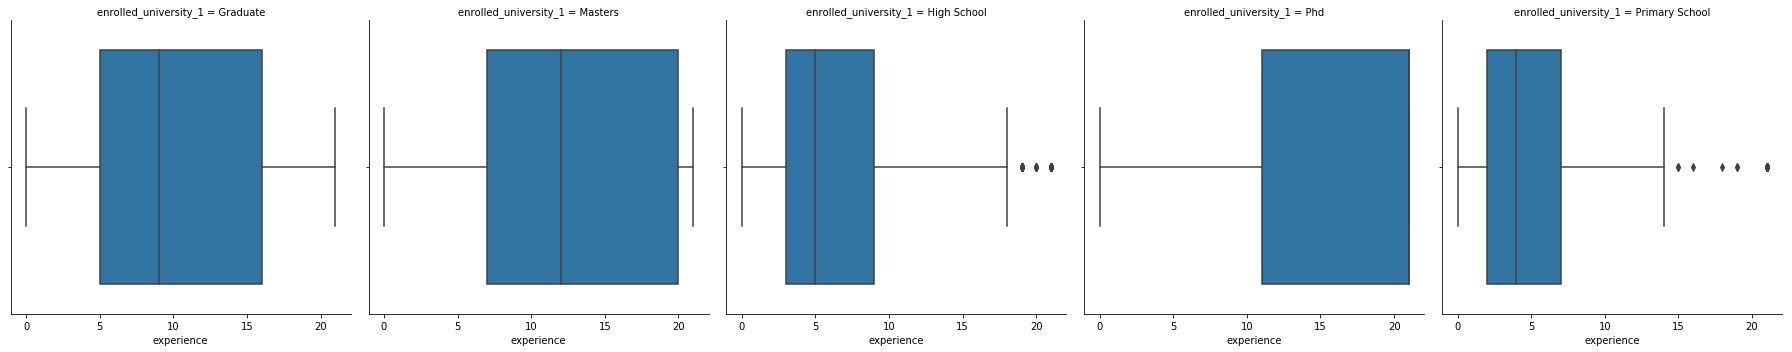

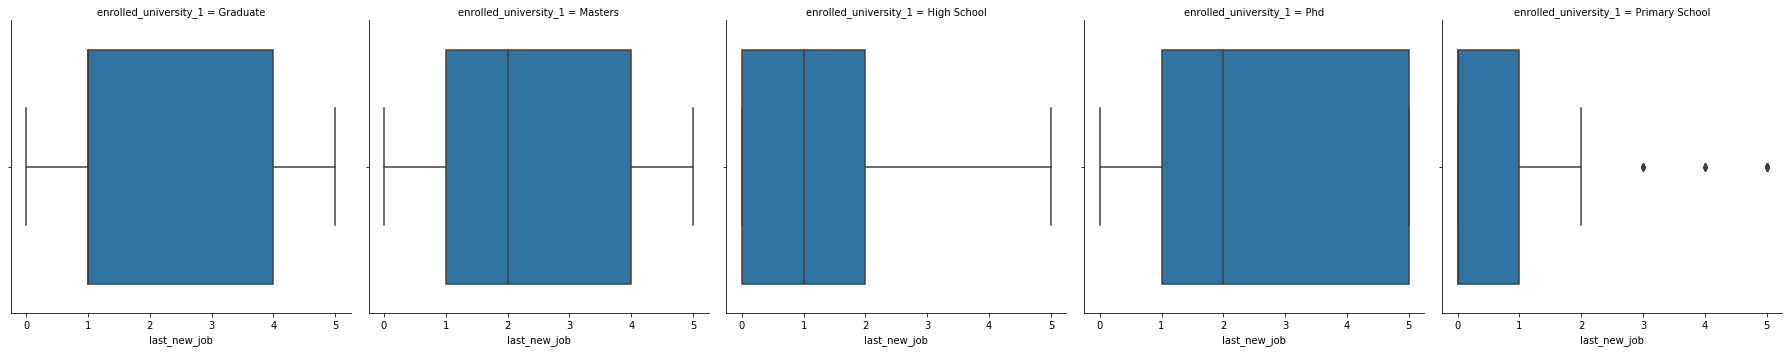

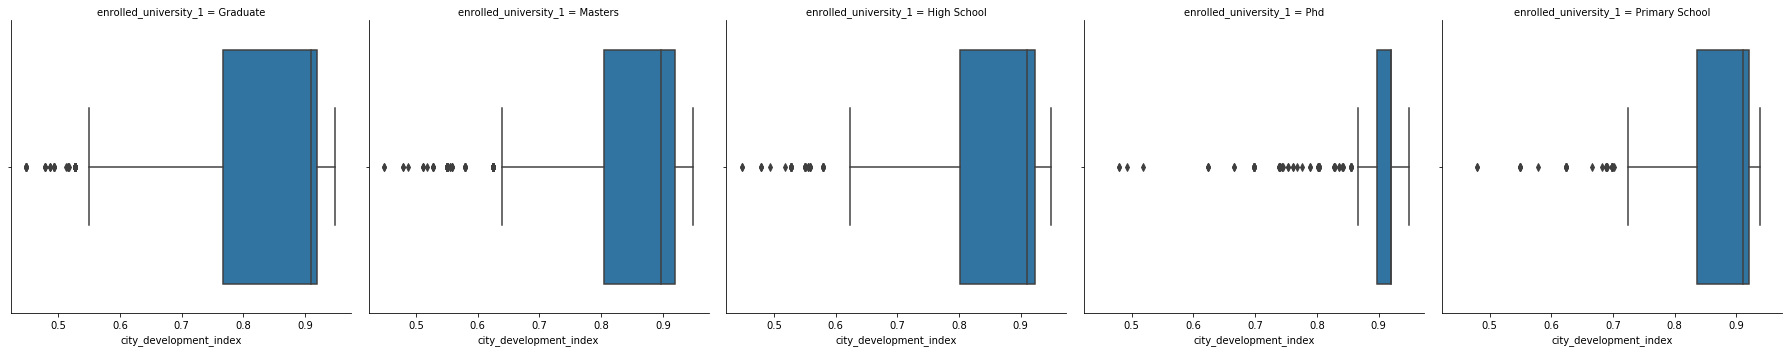

In [79]:
g = sns.FacetGrid(data = train_set, col = 'enrolled_university_1',size = 5)
g.map(sns.boxplot, 'experience')

g = sns.FacetGrid(data = train_set, col = 'enrolled_university_1',size = 5)
g.map(sns.boxplot, 'last_new_job')

g = sns.FacetGrid(data = train_set, col = 'enrolled_university_1',size = 5)
g.map(sns.boxplot, 'city_development_index')

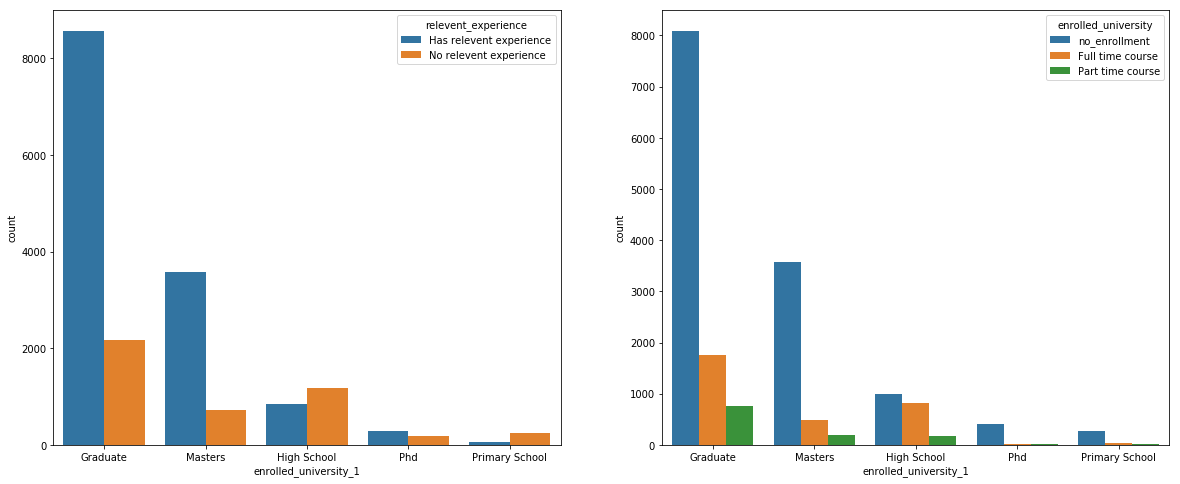

In [83]:
fig,ax = plt.subplots(ncols = 2)
sns.countplot(x = 'enrolled_university_1',hue = 'relevent_experience', data=  train_set,ax = ax[0])
sns.countplot(x = 'enrolled_university_1', hue = 'enrolled_university', data = train_set, ax = ax[1])

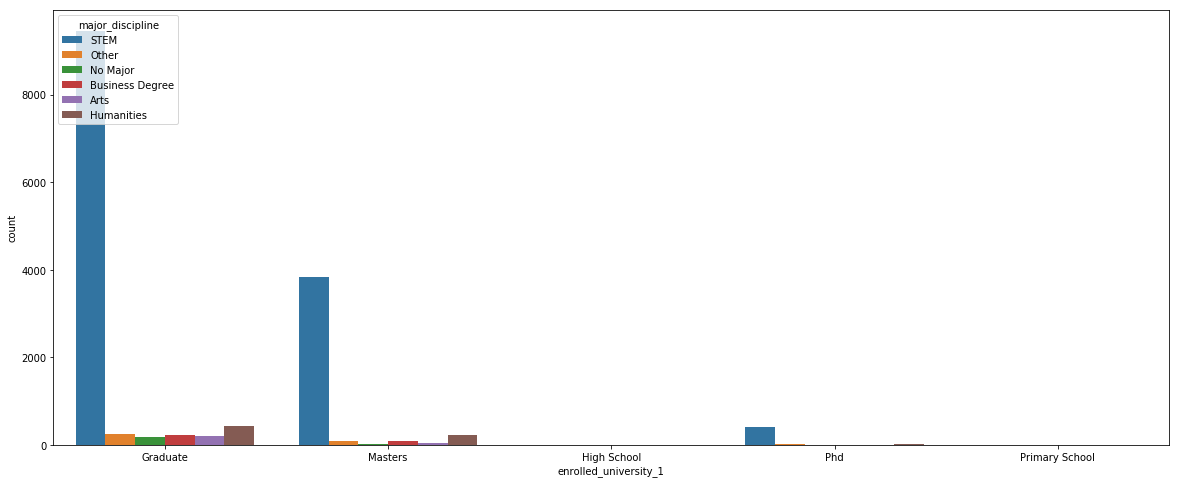

In [84]:
sns.countplot(x = 'enrolled_university_1', hue = 'major_discipline',data = train_set)

#### Major Discipline

C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


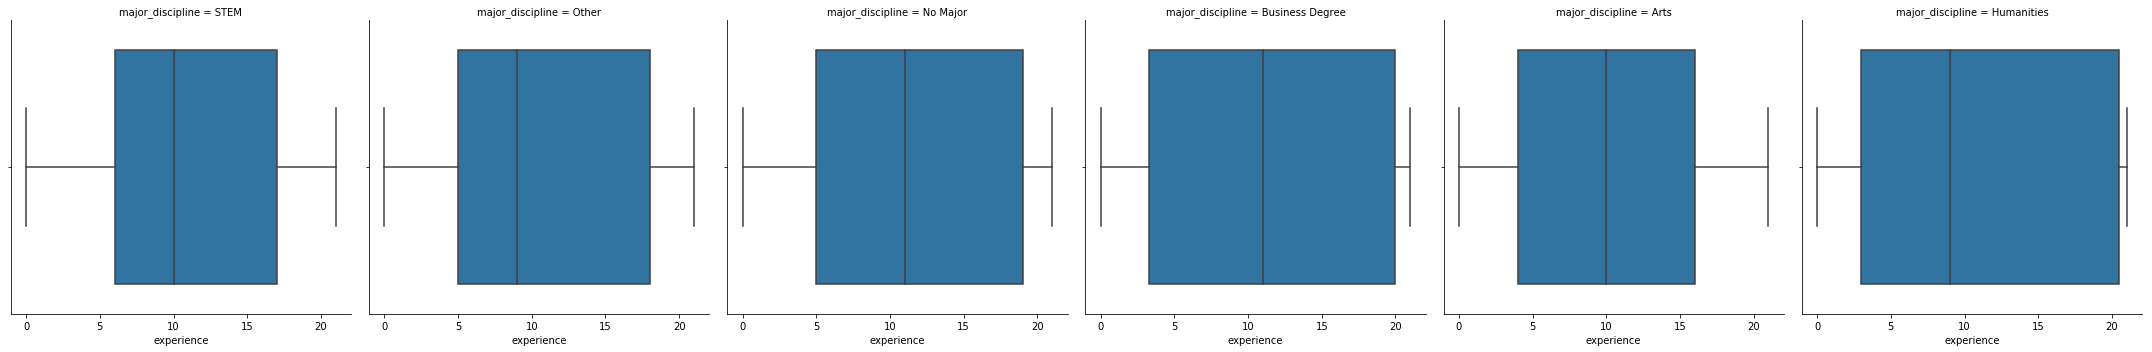

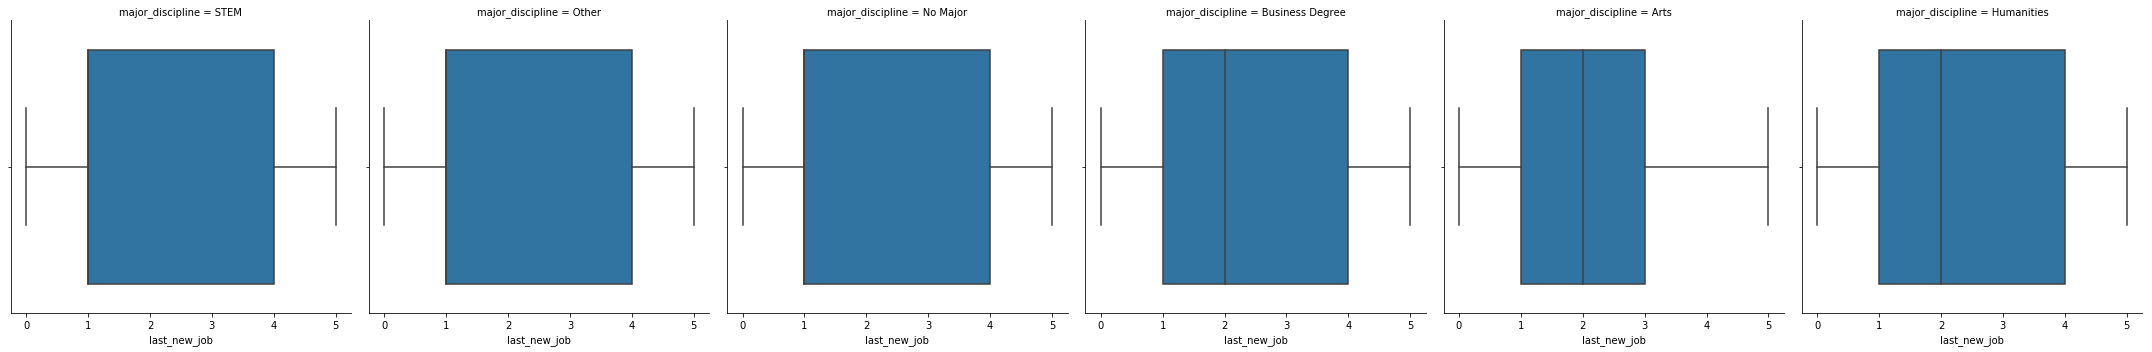

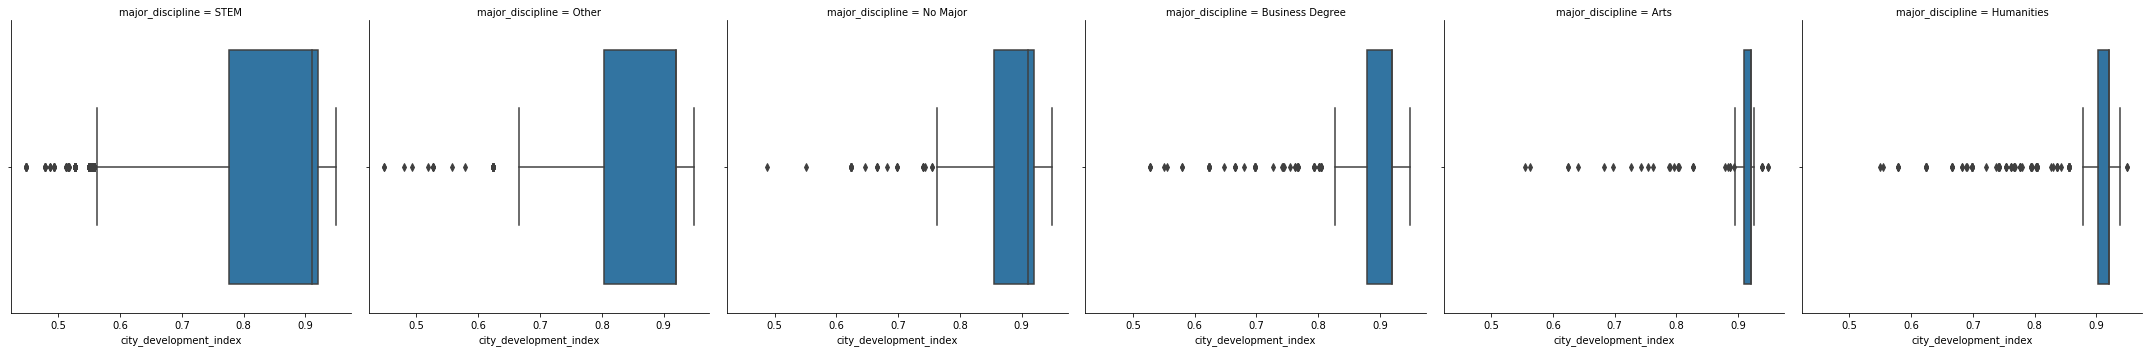

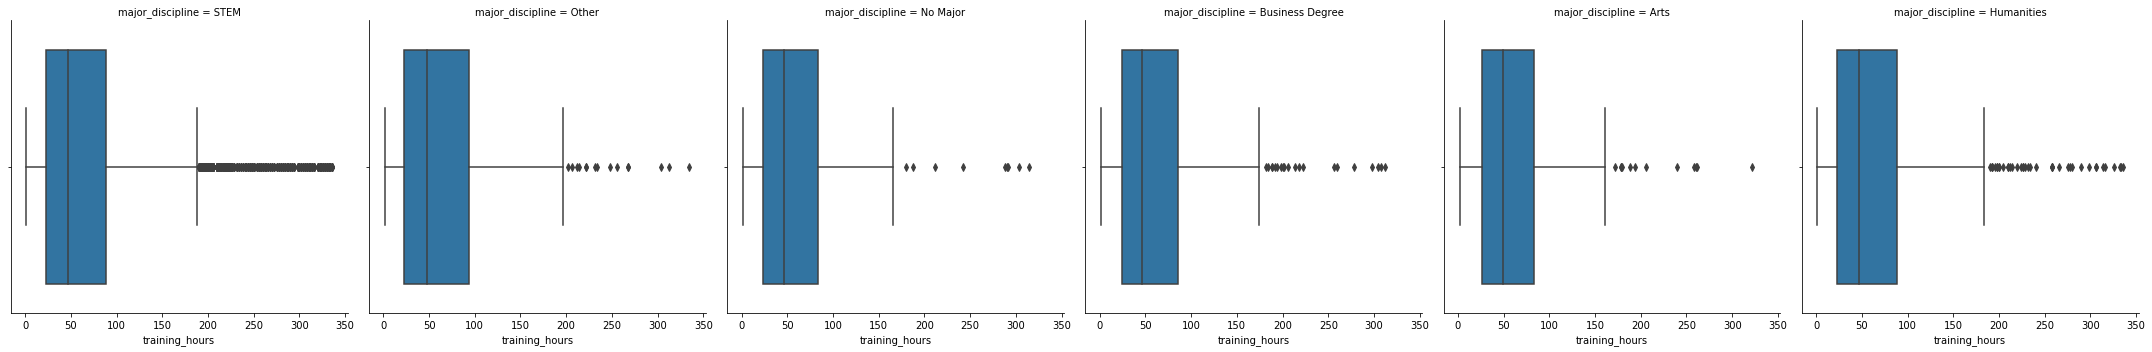

In [88]:
g = sns.FacetGrid(data = train_set, col = 'major_discipline',size = 5)
g.map(sns.boxplot, 'experience')

g = sns.FacetGrid(data = train_set, col = 'major_discipline',size = 5)
g.map(sns.boxplot, 'last_new_job')

g = sns.FacetGrid(data = train_set, col = 'major_discipline',size = 5)
g.map(sns.boxplot, 'city_development_index')

g = sns.FacetGrid(data = train_set, col = 'major_discipline',size = 5)
g.map(sns.boxplot, 'training_hours')

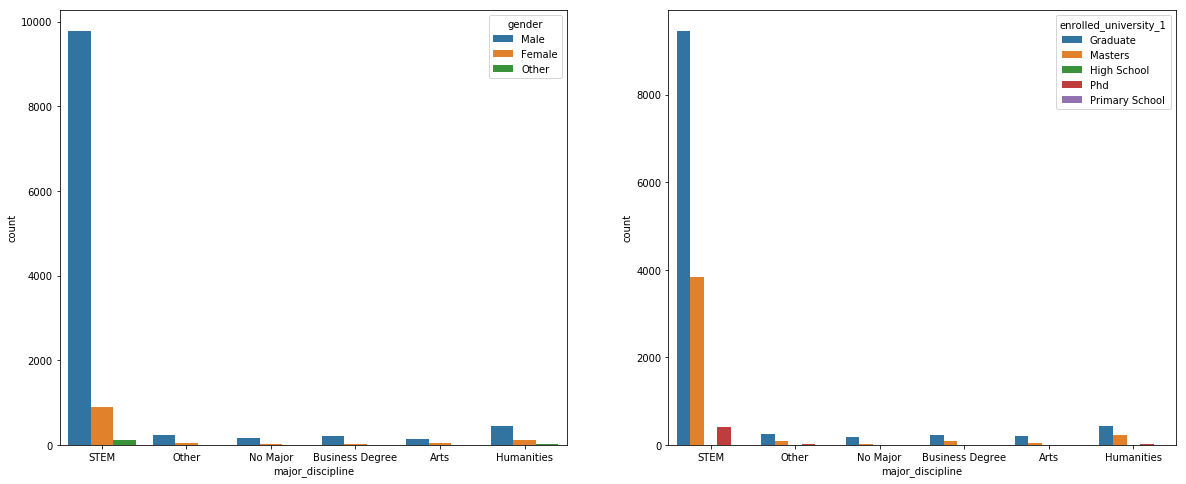

In [87]:
f,ax = plt.subplots(ncols = 2)
sns.countplot(x = 'major_discipline', hue = 'gender', data = train_set, ax=  ax[0])
sns.countplot(x = 'major_discipline', hue = 'enrolled_university_1', data = train_set, ax = ax[1])


#### Company_size

C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aashi\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


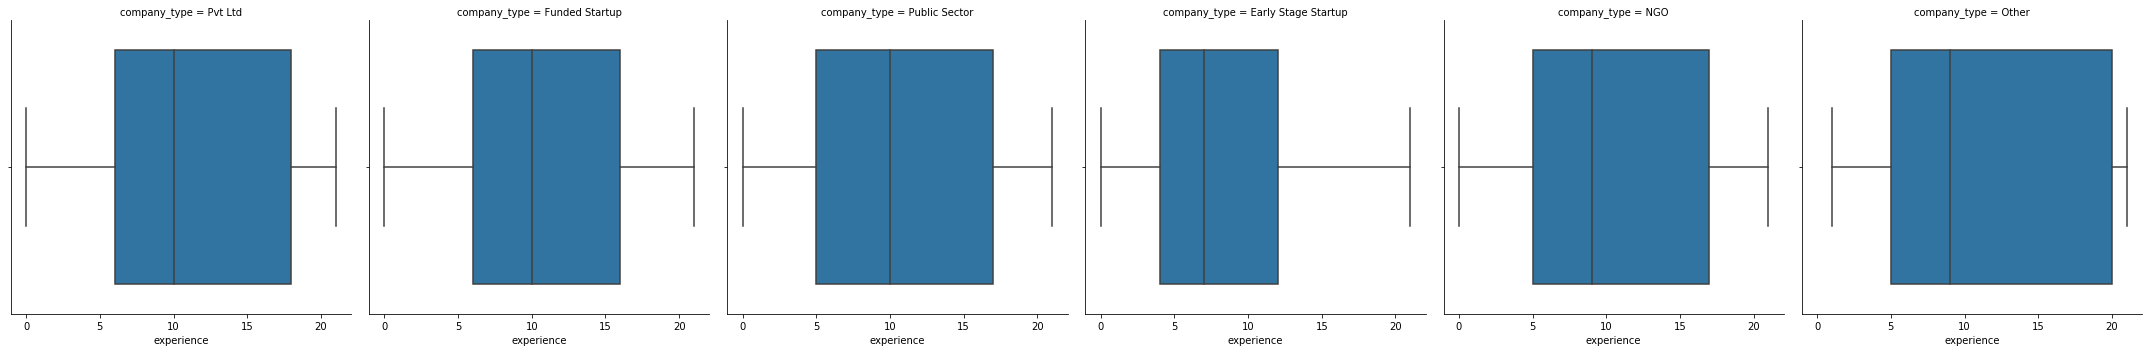

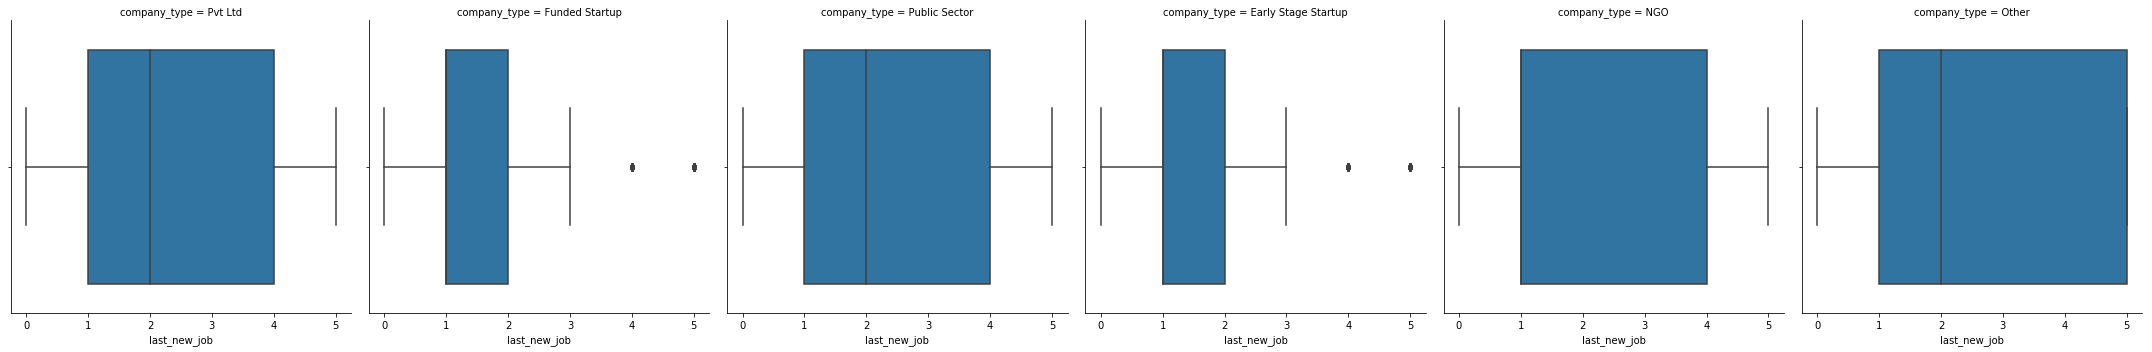

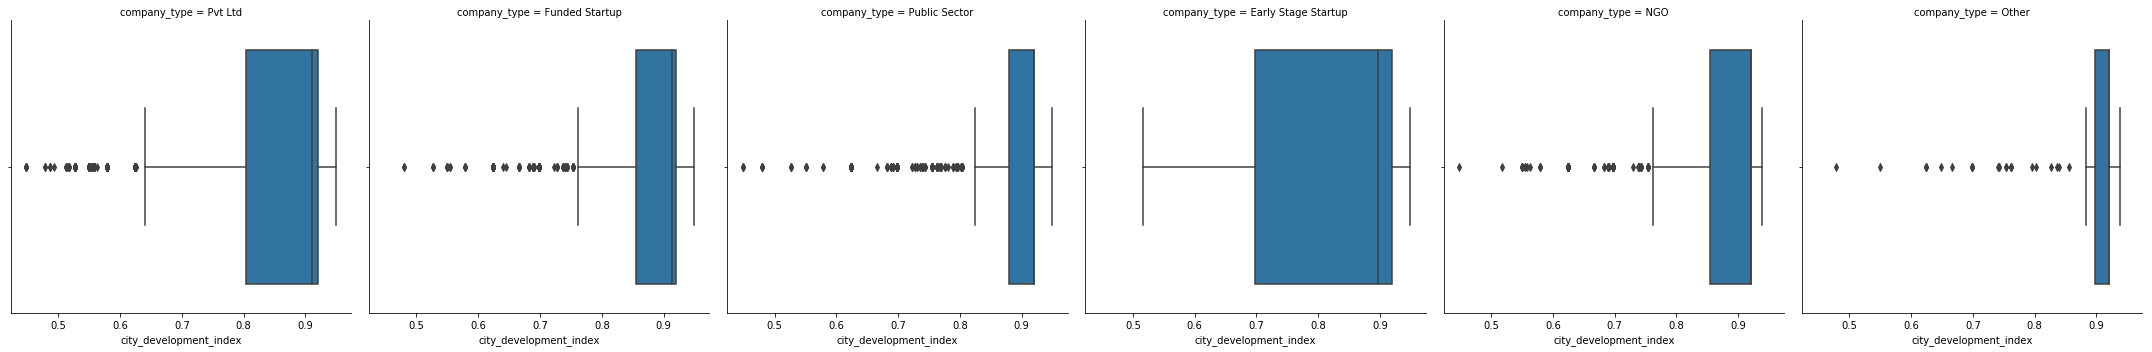

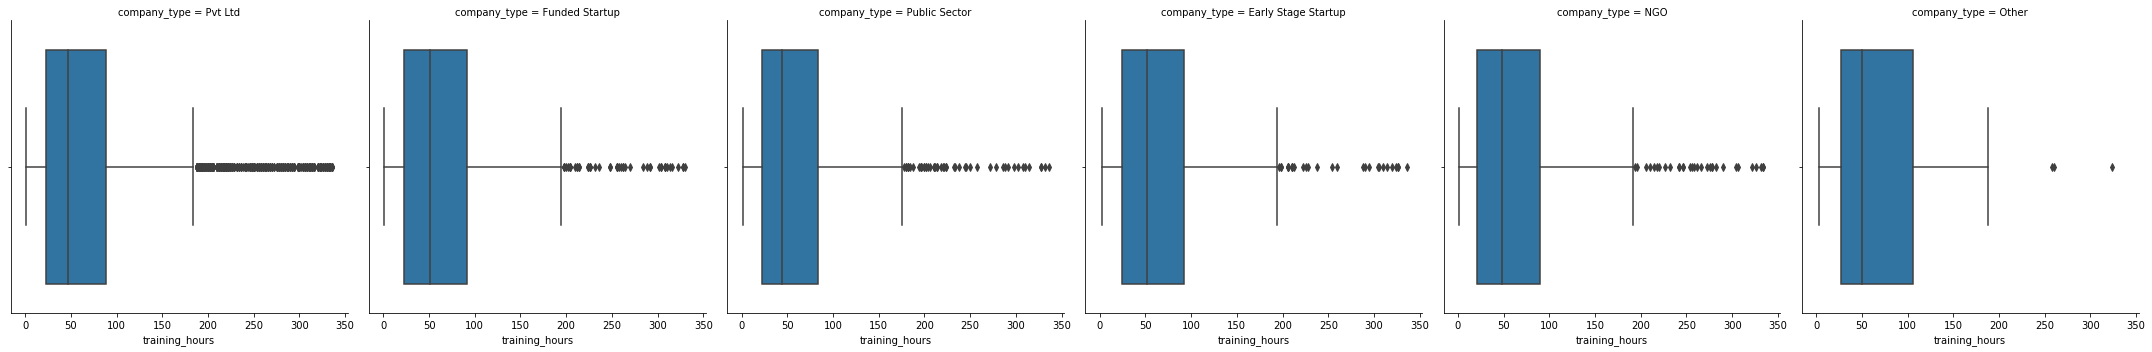

In [96]:
g = sns.FacetGrid(data = train_set, col = 'company_type',size = 5)
g.map(sns.boxplot, 'experience')

g = sns.FacetGrid(data = train_set, col = 'company_type',size = 5)
g.map(sns.boxplot, 'last_new_job')

g = sns.FacetGrid(data = train_set, col = 'company_type',size = 5)
g.map(sns.boxplot, 'city_development_index')

g = sns.FacetGrid(data = train_set, col = 'company_type',size = 5)
g.map(sns.boxplot, 'training_hours')

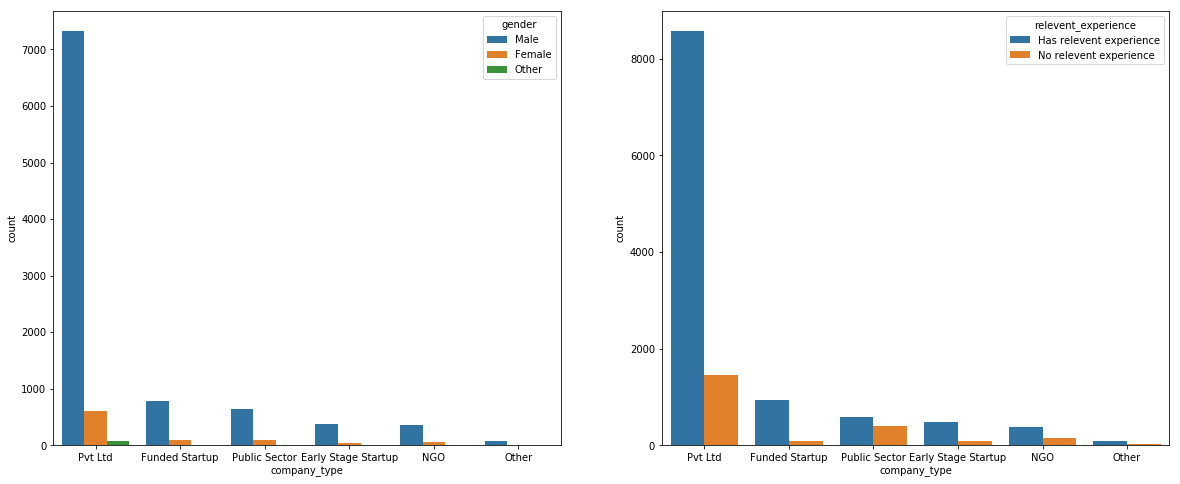

In [98]:
fig, ax = plt.subplots(ncols = 2)
sns.countplot(x = 'company_type', hue = 'gender', data = train_set, ax = ax[0])
sns.countplot(x = 'company_type', hue = 'relevent_experience', data = train_set, ax = ax[1])

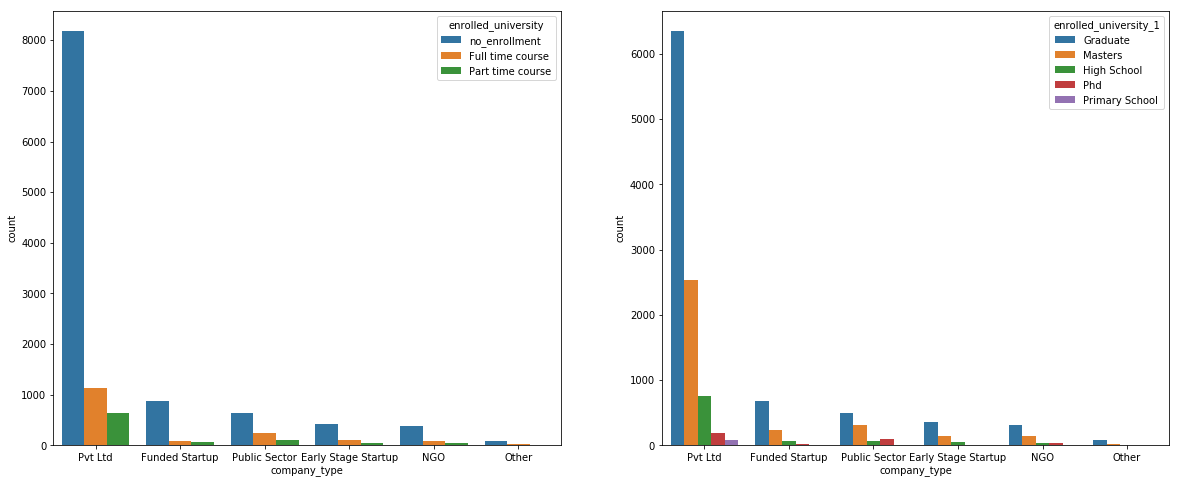

In [99]:
fig, ax = plt.subplots(ncols = 2)
sns.countplot(x = 'company_type', hue = 'enrolled_university', data = train_set, ax = ax[0])
sns.countplot(x = 'company_type', hue = 'enrolled_university_1', data = train_set, ax = ax[1])

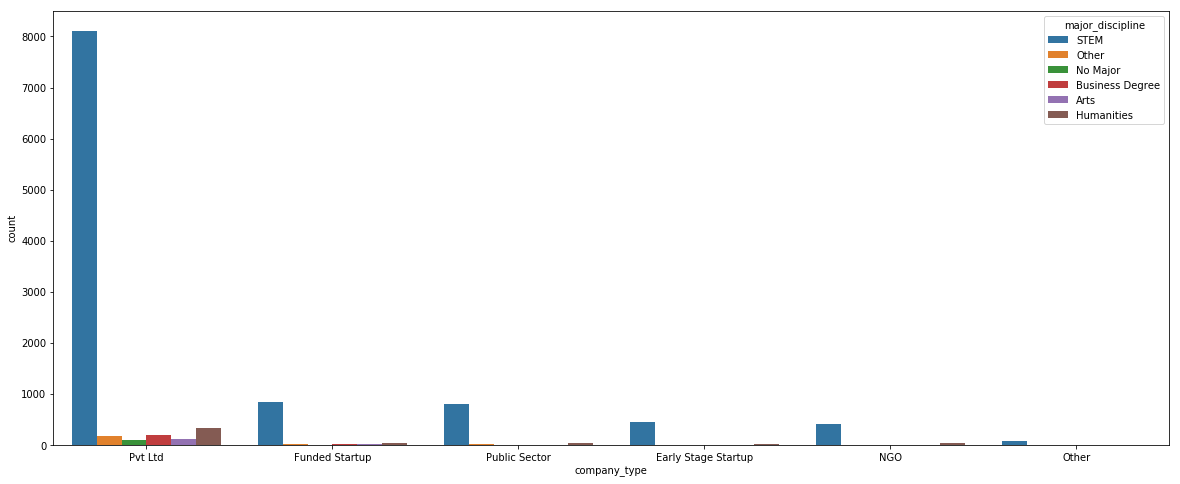

In [101]:
fig, ax = plt.subplots(ncols = 1)
sns.countplot(x = 'company_type', hue = 'major_discipline', data = train_set)
# sns.countplot(x = 'company_type', hue = 'enrolled_university_1', data = train_set, ax = ax[1])

#### Company_size

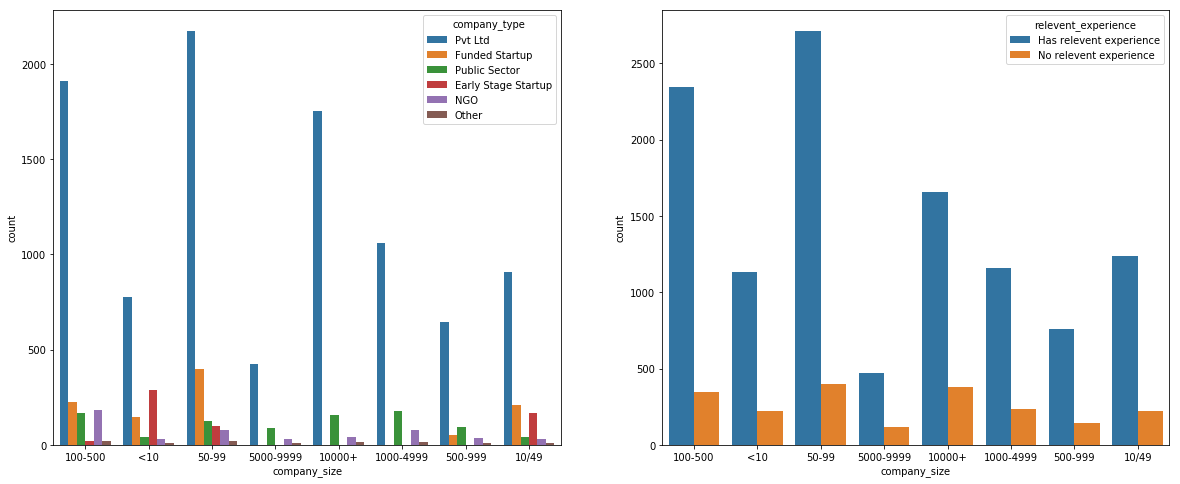

In [105]:
fig, ax = plt.subplots(ncols = 2)
sns.countplot(x = 'company_size', hue = 'company_type', data = train_set, ax = ax[0])
sns.countplot(x = 'company_size', hue = 'relevent_experience', data = train_set, ax = ax[1])

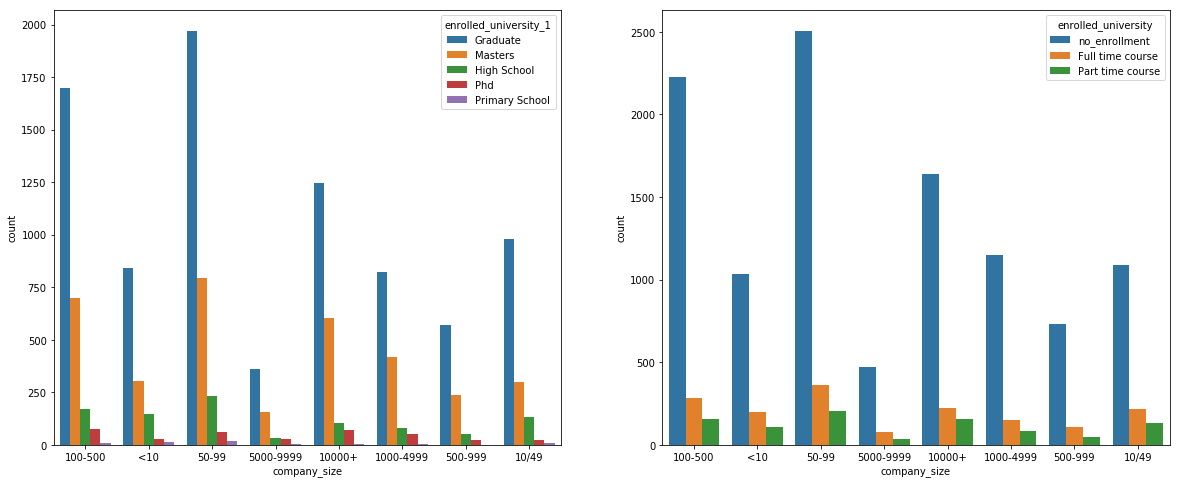

In [106]:
fig, ax = plt.subplots(ncols = 2)
sns.countplot(x = 'company_size', hue = 'enrolled_university_1', data = train_set, ax = ax[0])
sns.countplot(x = 'company_size', hue = 'enrolled_university', data = train_set, ax = ax[1])

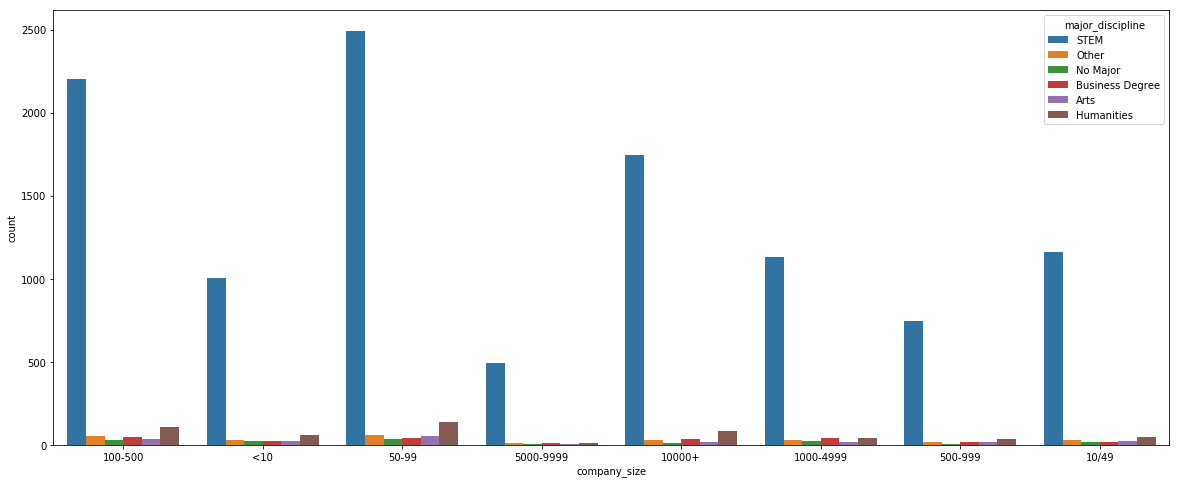

In [107]:
sns.countplot(x = 'company_size', hue = 'major_discipline', data = train_set)

#### Relation between numeric attributes

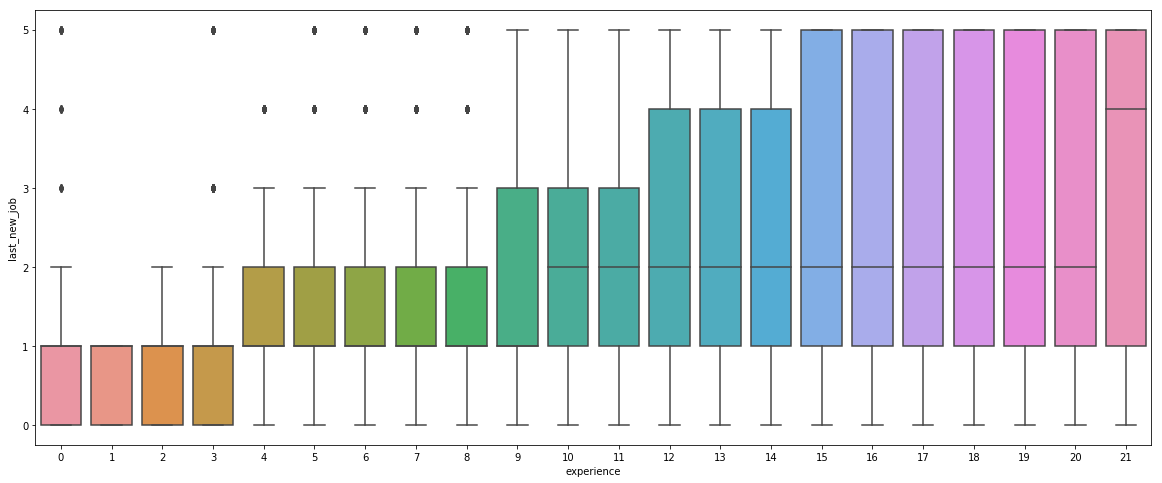

In [128]:
# sns.lmplot('experience','last_new_job', data = train_set)
sns.boxplot('experience','last_new_job', data = train_set)

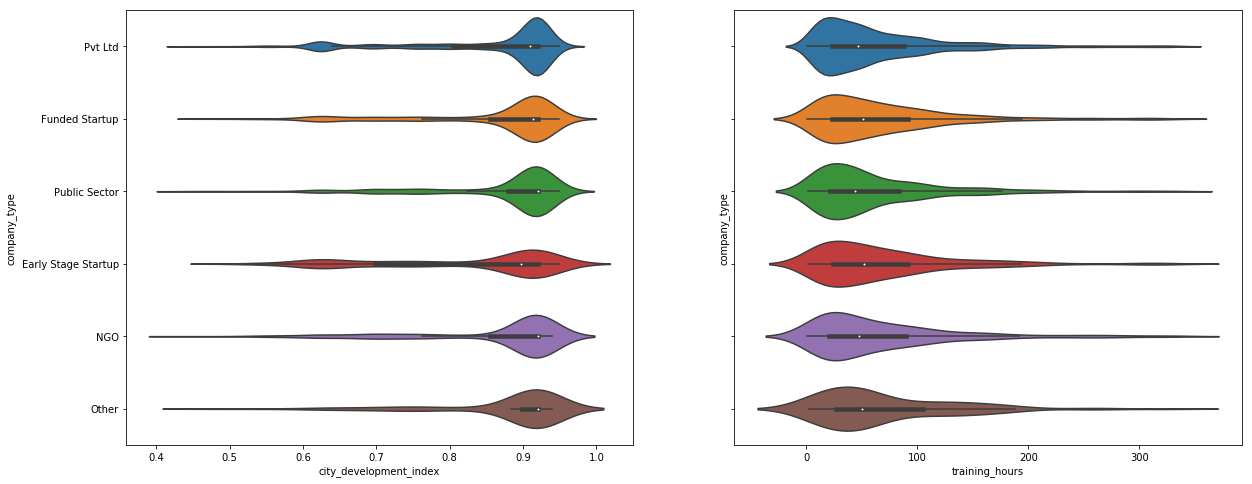

In [94]:
f,axes = plt.subplots(1,2,sharey=True)
sns.violinplot('city_development_index','company_type',data = train_set,size = 6,ax = axes[0])
sns.violinplot('training_hours','company_type',data = train_set,size = 6,ax = axes[1])
# sns.factorplot('enrolled_university_1','target', data = train_set, kind = 'violin',size = 7)

In [ ]:
sns.factorplot('city','target', data = train_set[train_set.city_development_index < 0.60],size = 8,kind ='violin')

# sns.swarmplot('city','target', data = train_set[train_set.city_development_index < 0.55])

### Function to predict missing values through RandomForest

In [15]:
def rf_classifier(x_train,y_train,x_test,n_est= 500, m_dep = 10):
    '''
    x_train: training_data
    y_train: target 
    x_test: testing_data
    n_est: no. of estimators
    m_dep: max_depth
    '''
    rf = RandomForestClassifier(n_estimators= n_est, max_depth = m_dep,n_jobs = 6,random_state = 42,oob_score=True)
    model = rf.fit(x_train,y_train)
    print(rf.score(x_train,y_train))
    return model.predict(x_test) 

def pred_missing(df,pred_col, cols,trans_col):
    
    lb = LabelEncoder()
    x_train = df[df[pred_col].notnull()][cols]
    x_test = df[df[pred_col].isnull()][cols]
    if trans_col != None:
        for i in trans_col:
            x_train[i] = lb.fit_transform(x_train[i].astype(str))
            x_test[i] = lb.fit_transform(x_test[i].astype(str))
        
    y_train = lb.fit_transform(df[df[pred_col].notnull()][pred_col])
    
    
    return lb.inverse_transform(rf_classifier(x_train,y_train,x_test))

## Removing Missing Values

To accomplish this task we will predict missing data or replace it with median value of the attribute.

In [144]:
train_temp = train_set.copy()
test_temp = test_set.copy()

In [154]:
train_set.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,enrolled_university_1,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1.0,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1.0,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2.0,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1.0,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2.0,88,1


In [133]:
test_temp.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
enrolled_university_1     0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

#### Imputing missing values for last_new_job

In [190]:
regr = RandomForestRegressor(max_depth = 10, n_estimators=100)
regr.fit(np.array(train_temp[train_temp.last_new_job.notnull()].experience).reshape((-1,1)),
         train_temp[train_temp.last_new_job.notnull()].last_new_job)
train_temp.loc[train_temp.last_new_job.isnull(),'last_new_job'] = regr.predict(np.array(train_temp[train_temp.last_new_job.isnull()].experience).reshape((-1,1))).round()


regr.fit(np.array(test_temp[test_temp.last_new_job.notnull()].experience).reshape((-1,1)),
         test_temp[test_temp.last_new_job.notnull()].last_new_job)
test_temp.loc[test_temp.last_new_job.isnull(),'last_new_job'] = regr.predict(np.array(test_temp[test_temp.last_new_job.isnull()].experience).reshape((-1,1))).round()


#### Imputing missing values for gender

In [146]:
#Imputing missing values for gender
col_for_gender = ['city','city_development_index','experience','last_new_job']
cat_cols = ['city']
train_temp.loc[train_temp.gender.isnull(), 'gender'] = pred_missing(train_temp,'gender',col_for_gender,cat_cols)

test_temp.loc[test_temp.gender.isnull(), 'gender'] = pred_missing(test_temp,'gender',col_for_gender,cat_cols)

0.905019305019305


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9112008940084243


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Imputing missing values for enrolled_university

In [191]:
col_for_en_u = ['city','city_development_index','experience','last_new_job','relevent_experience']
cat_cols = ['city','relevent_experience']
train_temp.loc[train_temp.enrolled_university.isnull(), 'enrolled_university'] = pred_missing(train_temp,
                                                                                              'enrolled_university',
                                                                                              col_for_en_u,
                                                                                              cat_cols)

test_temp.loc[test_temp.enrolled_university.isnull(), 'enrolled_university'] = pred_missing(test_temp,
                                                                                              'enrolled_university',
                                                                                              col_for_en_u,
                                                                                              cat_cols)

0.8080498803095252


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8121014787681454


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Imputing missing values for major_discipline

In [148]:
cat_cols = ['city']
train_temp.loc[train_temp.major_discipline.isnull(), 'major_discipline'] = pred_missing(train_temp,'major_discipline',col_for_gender,cat_cols)
test_temp.loc[test_temp.major_discipline.isnull(), 'major_discipline'] = pred_missing(test_temp,'major_discipline',col_for_gender,cat_cols)

0.8874749693172276


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8832752613240418


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Imputing missing values for enrolled_university_1

In [192]:
cols_for_enroll_uni_1 = ['city','last_new_job','relevent_experience','city_development_index','enrolled_university','major_discipline']
cat_cols = ['enrolled_university','major_discipline','city','relevent_experience']
train_temp.loc[train_temp.enrolled_university_1.isnull(), 'enrolled_university_1'] = pred_missing(train_temp,'enrolled_university_1',cols_for_enroll_uni_1, cat_cols)

test_temp.loc[test_temp.enrolled_university_1.isnull(), 'enrolled_university_1'] = pred_missing(test_temp,'enrolled_university_1',cols_for_enroll_uni_1, cat_cols)

0.7468496219546346


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7495555859428416


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Imputing missing values for company_type

In [150]:
cols_for_com_type = ['city_development_index','last_new_job','experience','relevent_experience','major_discipline']
cat_cols = ['major_discipline','relevent_experience']
train_temp.loc[train_temp.company_type.isnull(), 'company_type'] = pred_missing(train_temp,'company_type',cols_for_com_type, cat_cols)
test_temp.loc[test_temp.company_type.isnull(), 'company_type'] = pred_missing(test_temp,'company_type',cols_for_com_type, cat_cols)

0.7613781689611073


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7629782059676363


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Imputing missing values for company_size

In [151]:
cols_for_com_size = ['city_development_index','last_new_job','experience','major_discipline','company_size']
cat_cols = ['major_discipline','company_size']
train_temp.loc[train_temp.company_size.isnull(), 'company_size'] = pred_missing(train_temp,'company_size',cols_for_com_size, cat_cols)

test_temp.loc[test_temp.company_size.isnull(), 'company_size'] = pred_missing(test_temp,'company_size',cols_for_com_size, cat_cols)

1.0


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1.0


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Consider missing values as another category

In [10]:
def new_value(df,cols):
    for i in cols:
        df.loc[df[i].isnull(), i] = 'not null'
    return df

In [23]:
train_temp = train_set.copy()
test_temp = test_set.copy()


In [24]:
cols = ['gender','major_discipline','company_size','company_type']
train_temp = new_value(train_temp,cols)
test_temp = new_value(test_temp,cols)

In [25]:
# imputing missing value for last_new_job
exp_median = [np.median(train_temp[(train_temp.last_new_job.notnull()) & (train_temp.last_new_job == i)].experience) 
              for i in np.sort(train_temp.last_new_job.unique()[:-1])]
train_temp.loc[train_temp.last_new_job.isnull() , 'last_new_job'] = 1
test_temp.loc[test_temp.last_new_job.isnull() , 'last_new_job'] = 1


In [26]:
train_temp = train_temp[(train_temp.enrolled_university.notnull()) & (train_temp.enrolled_university_1.notnull())]

In [27]:
col_for_en_u = ['city_development_index','experience','last_new_job','relevent_experience','company_type','company_size']
cat_cols = ['relevent_experience','company_type','company_size']

# train_temp.loc[train_temp.enrolled_university.isnull(), 'enrolled_university'] = pred_missing(train_temp,
#                                                                                               'enrolled_university',
#                                                                                               col_for_en_u,
#                                                                                               cat_cols)

test_temp.loc[test_temp.enrolled_university.isnull(), 'enrolled_university'] = pred_missing(test_temp,
                                                                                              'enrolled_university',
                                                                                              col_for_en_u,
                                                                                              cat_cols)
# train_temp.loc[train_temp.enrolled_university_1.isnull(), 'enrolled_university_1'] = pred_missing(train_temp,
#                                                                                               'enrolled_university_1',
#                                                                                               col_for_en_u,
#                                                                                               cat_cols)

test_temp.loc[test_temp.enrolled_university_1.isnull(), 'enrolled_university_1'] = pred_missing(test_temp,
                                                                                              'enrolled_university_1',
                                                                                              col_for_en_u,
                                                                                              cat_cols)

0.8169854836521503


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6814576781074798


C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Predictions on stock data

In [38]:
pd.Series(train_temp.drop(['enrollee_id','target'],1).columns)

0                       city
1     city_development_index
2                     gender
3        relevent_experience
4        enrolled_university
5      enrolled_university_1
6           major_discipline
7                 experience
8               company_size
9               company_type
10              last_new_job
11            training_hours
dtype: object

In [39]:
x_train,x_test,y_train,y_test = train_test_split(train_temp.drop(['enrollee_id','target'],1),
                                                 train_temp.target,test_size = 0.2)

In [40]:
x_train.columns

Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'enrolled_university_1', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours'],
      dtype='object')

In [41]:
x_train = convert(x_train,['city', 'gender', 'relevent_experience',
       'enrolled_university', 'enrolled_university_1', 'major_discipline',
        'company_size', 'company_type'])
x_test = convert(x_test,['city', 'gender', 'relevent_experience',
       'enrolled_university', 'enrolled_university_1', 'major_discipline',
        'company_size', 'company_type'])


In [42]:
pd.value_counts(y_train)

0    12286
1     1837
Name: target, dtype: int64

In [ ]:
ctb = catboost.CatBoostClassifier(max_depth = 10,
                                 learning_rate = 0.05,
                                 iterations = 2000,
                                 thread_count = 6,l2_leaf_reg = 25)
cat_feat = [0,2,3,4,5,6,8,9]
model = ctb.fit(x_train.drop(['target'],1), x_train.target,cat_feat)


In [85]:
y_preds = model.predict(x_test.drop('target',1))
print(precision_score(x_test.target, y_preds),
recall_score(x_test.target, y_preds))

0.40384615384615385 0.04535637149028078


In [81]:
pd.value_counts(y_preds)

0.0    3608
1.0      52
dtype: int64

In [213]:
# y_preds = model.predict(test_temp.drop(['enrollee_id'],1))


make_submission(test_temp.enrollee_id,y_preds,['enrollee_id','target'],'submission_supermacy.csv')

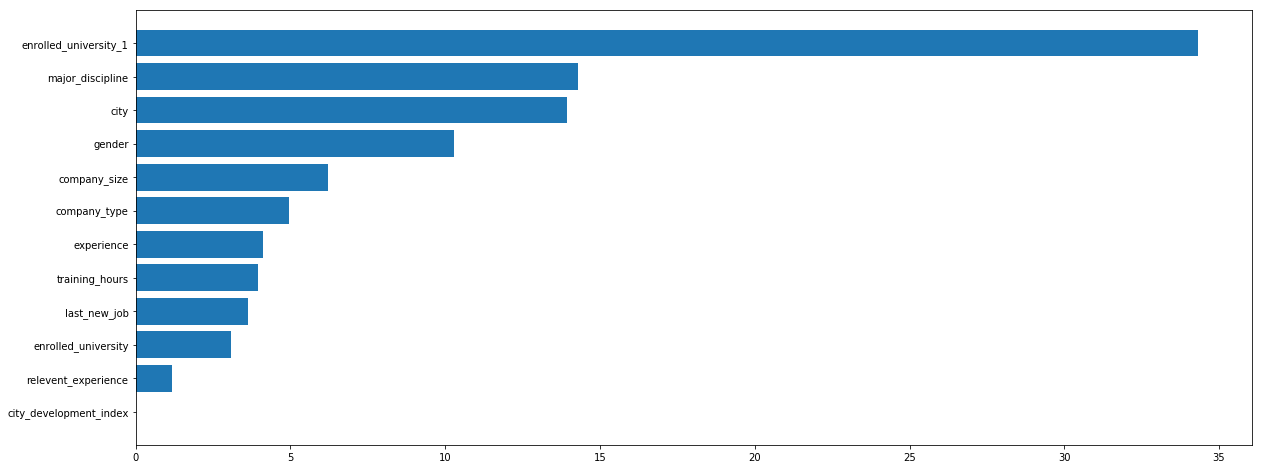

In [207]:
plot_imp_feat(train_temp.drop(['enrollee_id','target'],1).columns, ctb.feature_importances_)

## Applying SMOTE

In [31]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.under_sampling import ClusterCentroids

In [116]:
x_train_1 = train_temp.drop(['enrollee_id','target'],1)
x_test = test_temp.drop(['enrollee_id'],1)
y_train_1 = train_temp.target

In [117]:
x_train_1 = convert(x_train_1,['city', 'gender', 'relevent_experience',
       'enrolled_university', 'enrolled_university_1', 'major_discipline',
        'company_size', 'company_type'])
x_test = convert(x_test,['city', 'gender', 'relevent_experience',
       'enrolled_university', 'enrolled_university_1', 'major_discipline',
        'company_size', 'company_type'])

In [118]:
sm = SMOTEENN(random_state = 42,kind_smote='borderline2',kind_enn = 'mode')

In [119]:
x_train,y_train = sm.fit_sample(x_train_1,y_train_1)

C:\Users\aashi\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\Users\aashi\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [120]:
x_train = pd.DataFrame(x_train)
x_train.columns = train_temp.drop(['enrollee_id','target'],1).columns

In [121]:
x_train_rou = np.round(x_train.drop('city_development_index',1))
x_train_rou['city_development_index'] = x_train.city_development_index
x_train = x_train_rou.copy()

In [130]:
train_x,valid_x, train_y, valid_y = train_test_split(x_train,y_train,test_size= 0.2)

In [141]:
ctb = CBC( thread_count = 6,
          random_state= 42)
model = ctb.fit(x_train,y_train)

0:	learn: 0.6863444	total: 24.2ms	remaining: 24.2s
1:	learn: 0.6797331	total: 53.6ms	remaining: 26.7s
2:	learn: 0.6734099	total: 80.7ms	remaining: 26.8s
3:	learn: 0.6647649	total: 107ms	remaining: 26.7s
4:	learn: 0.6591746	total: 132ms	remaining: 26.2s
5:	learn: 0.6533825	total: 155ms	remaining: 25.7s
6:	learn: 0.6475155	total: 178ms	remaining: 25.3s
7:	learn: 0.6424572	total: 203ms	remaining: 25.1s
8:	learn: 0.6382827	total: 230ms	remaining: 25.3s
9:	learn: 0.6337072	total: 259ms	remaining: 25.6s
10:	learn: 0.6290752	total: 283ms	remaining: 25.4s
11:	learn: 0.6250217	total: 306ms	remaining: 25.2s
12:	learn: 0.6211236	total: 331ms	remaining: 25.1s
13:	learn: 0.6174937	total: 354ms	remaining: 24.9s
14:	learn: 0.6121640	total: 378ms	remaining: 24.8s
15:	learn: 0.6091523	total: 403ms	remaining: 24.8s
16:	learn: 0.6042297	total: 431ms	remaining: 24.9s
17:	learn: 0.6014318	total: 460ms	remaining: 25.1s
18:	learn: 0.5985965	total: 484ms	remaining: 25s
19:	learn: 0.5959050	total: 506ms	remain

167:	learn: 0.4393054	total: 4.11s	remaining: 20.4s
168:	learn: 0.4382321	total: 4.14s	remaining: 20.3s
169:	learn: 0.4379394	total: 4.16s	remaining: 20.3s
170:	learn: 0.4376865	total: 4.18s	remaining: 20.3s
171:	learn: 0.4371210	total: 4.21s	remaining: 20.2s
172:	learn: 0.4367306	total: 4.23s	remaining: 20.2s
173:	learn: 0.4363633	total: 4.25s	remaining: 20.2s
174:	learn: 0.4359758	total: 4.27s	remaining: 20.1s
175:	learn: 0.4358268	total: 4.29s	remaining: 20.1s
176:	learn: 0.4355654	total: 4.32s	remaining: 20.1s
177:	learn: 0.4352650	total: 4.34s	remaining: 20.1s
178:	learn: 0.4349650	total: 4.37s	remaining: 20s
179:	learn: 0.4347025	total: 4.39s	remaining: 20s
180:	learn: 0.4344520	total: 4.41s	remaining: 20s
181:	learn: 0.4341008	total: 4.44s	remaining: 19.9s
182:	learn: 0.4338886	total: 4.46s	remaining: 19.9s
183:	learn: 0.4335496	total: 4.48s	remaining: 19.9s
184:	learn: 0.4332672	total: 4.5s	remaining: 19.8s
185:	learn: 0.4330499	total: 4.53s	remaining: 19.8s
186:	learn: 0.43284

326:	learn: 0.3956565	total: 7.99s	remaining: 16.4s
327:	learn: 0.3954081	total: 8.02s	remaining: 16.4s
328:	learn: 0.3951565	total: 8.04s	remaining: 16.4s
329:	learn: 0.3947491	total: 8.06s	remaining: 16.4s
330:	learn: 0.3944564	total: 8.09s	remaining: 16.4s
331:	learn: 0.3941843	total: 8.11s	remaining: 16.3s
332:	learn: 0.3939587	total: 8.13s	remaining: 16.3s
333:	learn: 0.3937705	total: 8.16s	remaining: 16.3s
334:	learn: 0.3935108	total: 8.18s	remaining: 16.2s
335:	learn: 0.3933395	total: 8.21s	remaining: 16.2s
336:	learn: 0.3932190	total: 8.24s	remaining: 16.2s
337:	learn: 0.3930450	total: 8.26s	remaining: 16.2s
338:	learn: 0.3927817	total: 8.28s	remaining: 16.1s
339:	learn: 0.3926169	total: 8.3s	remaining: 16.1s
340:	learn: 0.3923242	total: 8.33s	remaining: 16.1s
341:	learn: 0.3921165	total: 8.35s	remaining: 16.1s
342:	learn: 0.3919227	total: 8.37s	remaining: 16s
343:	learn: 0.3917924	total: 8.39s	remaining: 16s
344:	learn: 0.3915549	total: 8.42s	remaining: 16s
345:	learn: 0.39131

491:	learn: 0.3572624	total: 12.1s	remaining: 12.5s
492:	learn: 0.3570725	total: 12.1s	remaining: 12.5s
493:	learn: 0.3569315	total: 12.2s	remaining: 12.4s
494:	learn: 0.3567077	total: 12.2s	remaining: 12.4s
495:	learn: 0.3564910	total: 12.2s	remaining: 12.4s
496:	learn: 0.3563586	total: 12.2s	remaining: 12.4s
497:	learn: 0.3561859	total: 12.2s	remaining: 12.3s
498:	learn: 0.3559120	total: 12.3s	remaining: 12.3s
499:	learn: 0.3558216	total: 12.3s	remaining: 12.3s
500:	learn: 0.3557570	total: 12.3s	remaining: 12.3s
501:	learn: 0.3555175	total: 12.3s	remaining: 12.2s
502:	learn: 0.3553522	total: 12.4s	remaining: 12.2s
503:	learn: 0.3550575	total: 12.4s	remaining: 12.2s
504:	learn: 0.3549551	total: 12.4s	remaining: 12.2s
505:	learn: 0.3547811	total: 12.4s	remaining: 12.2s
506:	learn: 0.3547039	total: 12.5s	remaining: 12.1s
507:	learn: 0.3545445	total: 12.5s	remaining: 12.1s
508:	learn: 0.3543341	total: 12.5s	remaining: 12.1s
509:	learn: 0.3540821	total: 12.5s	remaining: 12.1s
510:	learn: 

657:	learn: 0.3324050	total: 16.2s	remaining: 8.42s
658:	learn: 0.3322333	total: 16.2s	remaining: 8.4s
659:	learn: 0.3321224	total: 16.3s	remaining: 8.38s
660:	learn: 0.3320257	total: 16.3s	remaining: 8.35s
661:	learn: 0.3319468	total: 16.3s	remaining: 8.33s
662:	learn: 0.3317624	total: 16.3s	remaining: 8.3s
663:	learn: 0.3316555	total: 16.4s	remaining: 8.28s
664:	learn: 0.3315819	total: 16.4s	remaining: 8.25s
665:	learn: 0.3313938	total: 16.4s	remaining: 8.22s
666:	learn: 0.3312859	total: 16.4s	remaining: 8.2s
667:	learn: 0.3311562	total: 16.5s	remaining: 8.18s
668:	learn: 0.3310883	total: 16.5s	remaining: 8.16s
669:	learn: 0.3309764	total: 16.5s	remaining: 8.14s
670:	learn: 0.3309055	total: 16.5s	remaining: 8.11s
671:	learn: 0.3307647	total: 16.6s	remaining: 8.09s
672:	learn: 0.3305928	total: 16.6s	remaining: 8.06s
673:	learn: 0.3305013	total: 16.6s	remaining: 8.03s
674:	learn: 0.3304126	total: 16.6s	remaining: 8.01s
675:	learn: 0.3302958	total: 16.7s	remaining: 7.99s
676:	learn: 0.3

818:	learn: 0.3157074	total: 20.2s	remaining: 4.46s
819:	learn: 0.3155422	total: 20.2s	remaining: 4.43s
820:	learn: 0.3154515	total: 20.2s	remaining: 4.41s
821:	learn: 0.3153317	total: 20.2s	remaining: 4.38s
822:	learn: 0.3151723	total: 20.3s	remaining: 4.36s
823:	learn: 0.3150717	total: 20.3s	remaining: 4.33s
824:	learn: 0.3149751	total: 20.3s	remaining: 4.31s
825:	learn: 0.3148713	total: 20.3s	remaining: 4.28s
826:	learn: 0.3148328	total: 20.4s	remaining: 4.26s
827:	learn: 0.3147104	total: 20.4s	remaining: 4.23s
828:	learn: 0.3146774	total: 20.4s	remaining: 4.21s
829:	learn: 0.3146240	total: 20.4s	remaining: 4.18s
830:	learn: 0.3145874	total: 20.5s	remaining: 4.16s
831:	learn: 0.3144870	total: 20.5s	remaining: 4.13s
832:	learn: 0.3144468	total: 20.5s	remaining: 4.11s
833:	learn: 0.3143549	total: 20.5s	remaining: 4.08s
834:	learn: 0.3143257	total: 20.5s	remaining: 4.06s
835:	learn: 0.3141871	total: 20.6s	remaining: 4.03s
836:	learn: 0.3140795	total: 20.6s	remaining: 4.01s
837:	learn: 

977:	learn: 0.3034635	total: 23.8s	remaining: 536ms
978:	learn: 0.3033881	total: 23.9s	remaining: 512ms
979:	learn: 0.3032802	total: 23.9s	remaining: 487ms
980:	learn: 0.3032799	total: 23.9s	remaining: 463ms
981:	learn: 0.3032391	total: 23.9s	remaining: 439ms
982:	learn: 0.3031707	total: 23.9s	remaining: 414ms
983:	learn: 0.3031079	total: 24s	remaining: 390ms
984:	learn: 0.3030175	total: 24s	remaining: 365ms
985:	learn: 0.3029615	total: 24s	remaining: 341ms
986:	learn: 0.3028314	total: 24s	remaining: 317ms
987:	learn: 0.3027352	total: 24.1s	remaining: 292ms
988:	learn: 0.3026856	total: 24.1s	remaining: 268ms
989:	learn: 0.3026770	total: 24.1s	remaining: 244ms
990:	learn: 0.3026102	total: 24.1s	remaining: 219ms
991:	learn: 0.3024903	total: 24.2s	remaining: 195ms
992:	learn: 0.3024053	total: 24.2s	remaining: 170ms
993:	learn: 0.3023557	total: 24.2s	remaining: 146ms
994:	learn: 0.3023389	total: 24.2s	remaining: 122ms
995:	learn: 0.3022581	total: 24.3s	remaining: 97.4ms
996:	learn: 0.30219

In [111]:
# params = [{'l2_leaf_reg':[5,25], 'learning_rate': [0.01,0.07,0.1,0.3,0.5],
#          'iterations':[500,1000,1500,2000]}]

# scores = ['precision','recall']

# for score in scores:
# #     print(score)
#     clf = GridSearchCV(CBC(thread_count=6,random_state=42), params, cv = 2,
#                       scoring = '%s_macro' % score)
    
#     clf.fit(x_train,y_train)
    
#     print('Best parameters found on the development set:\n')
#     print(clf.best_params_)
    
#     print('\nGrid scores on development set:\n')
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
    
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print('%0.3f (+/-%0.03f) for %r' 
#              % (mean, std *2, params))
    
#     print('\nDetailed classification report:\n')
#     print('The model is trained on the full development set.')
#     print('The scores are computed on the full evaluation set.\n')
    
#     y_true, y_pred = y_test, clf.predict(x_test)
#     print(classification_report(y_true, y_pred))
#     print('\n')
# # ctb = catboost.CatBoostClassifier(
# #                                  thread_count = 6,random_state= 42)
# # cat_feat = [0,2,3,4,5,6,8,9]
# # model = ctb.fit(x_train,y_train)


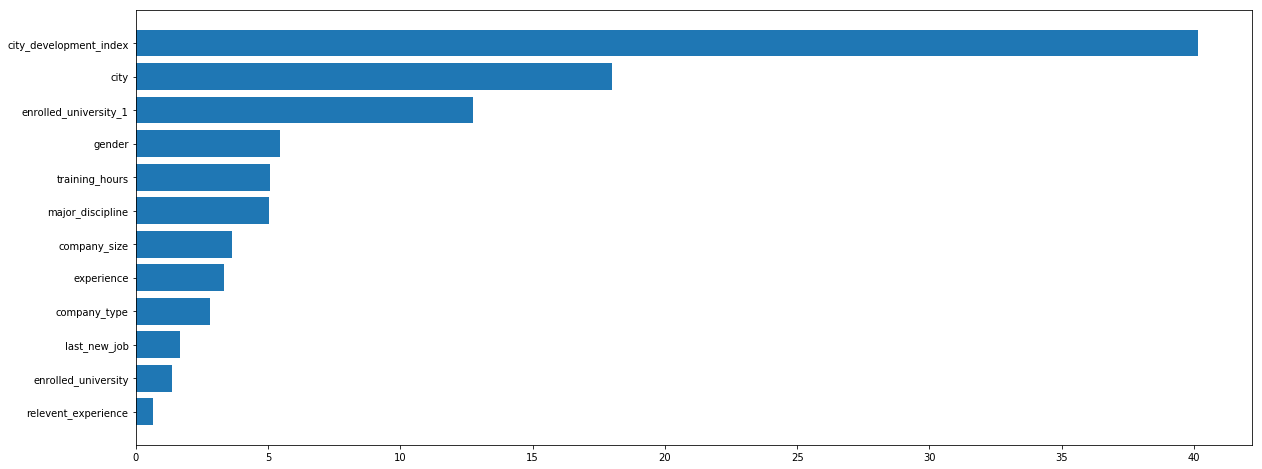

In [123]:
plot_imp_feat(x_train.columns,ctb.feature_importances_)

In [142]:
y_preds = model.predict(x_test)

# print(classification_report(y_test,y_preds))

In [144]:
pd.value_counts(y_preds)

0.0    14893
1.0      128
dtype: int64

In [152]:
make_submission(test_temp.enrollee_id,y_preds,['enrollee_id','target'], name = 'submission_supermacy.csv')

In [47]:
x_train = pd.DataFrame(x_train)
encoded_train = pd.concat([x_train, pd.DataFrame(y_train)],axis = 1)

encoded_train.columns = train_temp.drop(['enrollee_id'],1).columns

### RF classifier

In [359]:
y_preds = rf_classifier(x_train,y_train,x_test,n_est = 3000,m_dep = 7)
make_submission(test_temp.enrollee_id,y_preds,['enrollee_id','target'], name = 'submission_supermacy.csv')


0.7523014256619145


### XGB classifier

In [36]:
from xgboost import XGBClassifier as xgbc
import xgboost

In [48]:
x_train.columns = train_temp.drop(['enrollee_id','target'],1).columns

In [102]:
x_train['city_dev_ind_range'] =pd.cut(x_train.city_development_index,bins = 20)
# test_temp['city_dev_ind_range'] =pd.cut(test_temp.city_development_index,bins = 20)

In [103]:
x_train = convert(x_train,['city_dev_ind_range'])

In [104]:
train_x,valid_x, train_y, valid_y = train_test_split(x_train,y_train, test_size = 0.2)

In [145]:
xgm = xgbc(n_jobs = 6, random_state = 42)
model = xgm.fit(x_train,y_train)

In [147]:
x_test.columns = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'enrolled_university_1', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours', 'city_development_index']

In [148]:
y_preds = model.predict(x_test)
# make_submission(test_temp.enrollee_id,y_preds,['enrollee_id','target'], name = 'submission_supermacy.csv')

C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [151]:
pd.value_counts(y_preds)

0    14424
1      597
dtype: int64

In [139]:
roc_auc_score(valid_y,y_preds)

0.7946649698690696

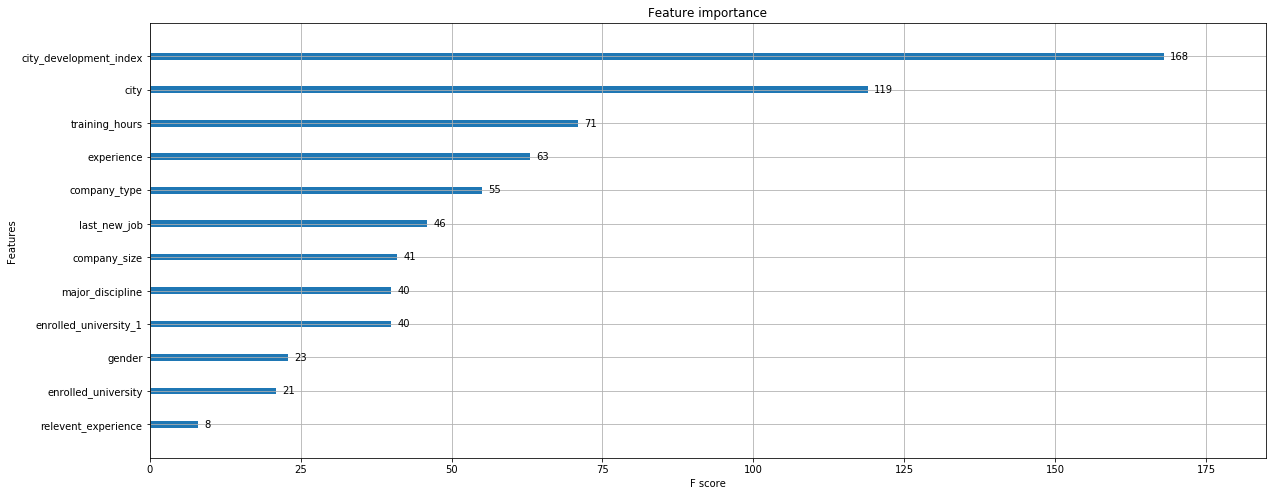

In [136]:
xgboost.plot_importance(model)

## Undersampling the data

In [114]:
x_train_temp = train_temp.drop(['enrollee_id'],1)

In [113]:
temp = x_train_temp[(x_train_temp.major_discipline == 'STEM')]
for_21,_ = train_test_split(temp, random_state = 42, test_size = 0.4,shuffle = True)


In [107]:
x_train = x_train_temp[(x_train_temp.major_discipline != 'STEM' )]
x_train = x_train.append(for_21)

## Some Graphs

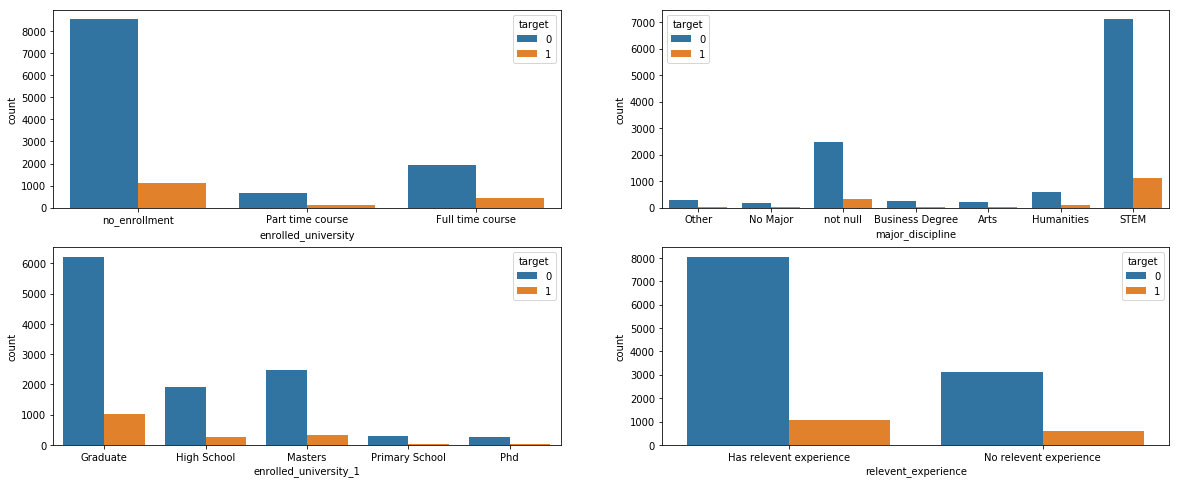

In [108]:
fig, ax = plt.subplots(nrows = 2,ncols = 2)
# sns.countplot('city_development_index',hue = 'target', data = train_set, ax = ax[0])
sns.countplot('enrolled_university',hue = 'target', data = x_train, ax = ax[0][0])
sns.countplot('enrolled_university_1',hue = 'target', data = x_train, ax = ax[1][0])
sns.countplot('major_discipline',hue = 'target', data = x_train, ax = ax[0][1])
sns.countplot('relevent_experience',hue = 'target', data = x_train, ax = ax[1][1])

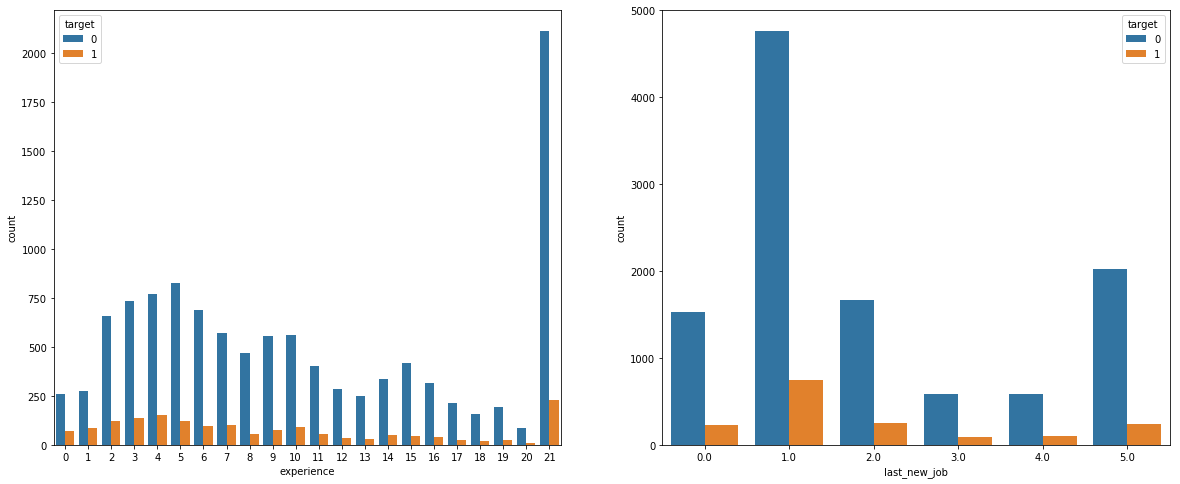

In [109]:
fig,ax = plt.subplots(ncols = 2)
sns.countplot('experience',hue = 'target', data = x_train,ax = ax[0])
sns.countplot('last_new_job', hue = 'target', data = x_train,ax = ax[1])

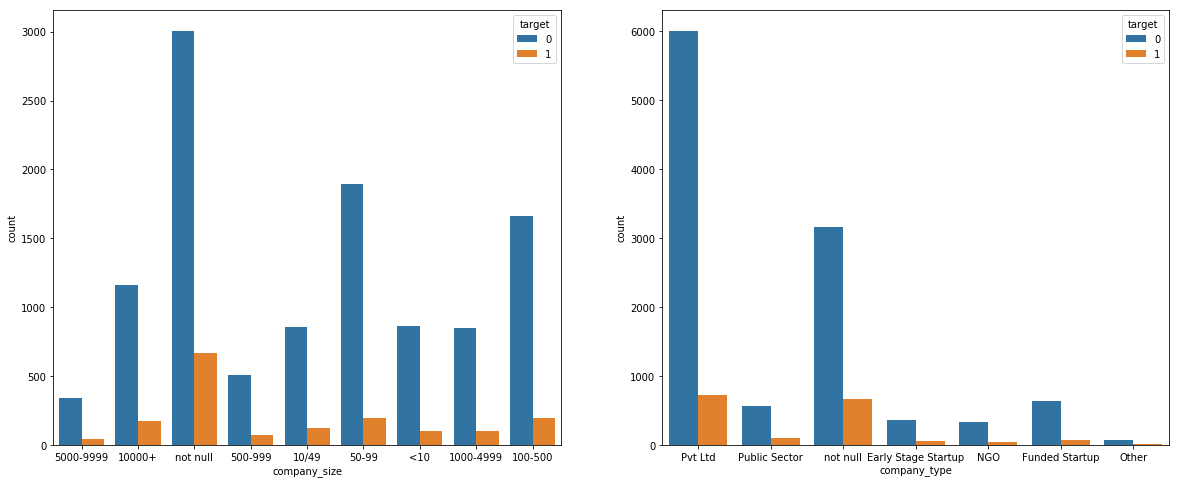

In [110]:
fig,ax = plt.subplots(ncols = 2)
sns.countplot('company_size',hue = 'target', data = x_train,ax = ax[0])
sns.countplot('company_type', hue = 'target', data = x_train,ax = ax[1])

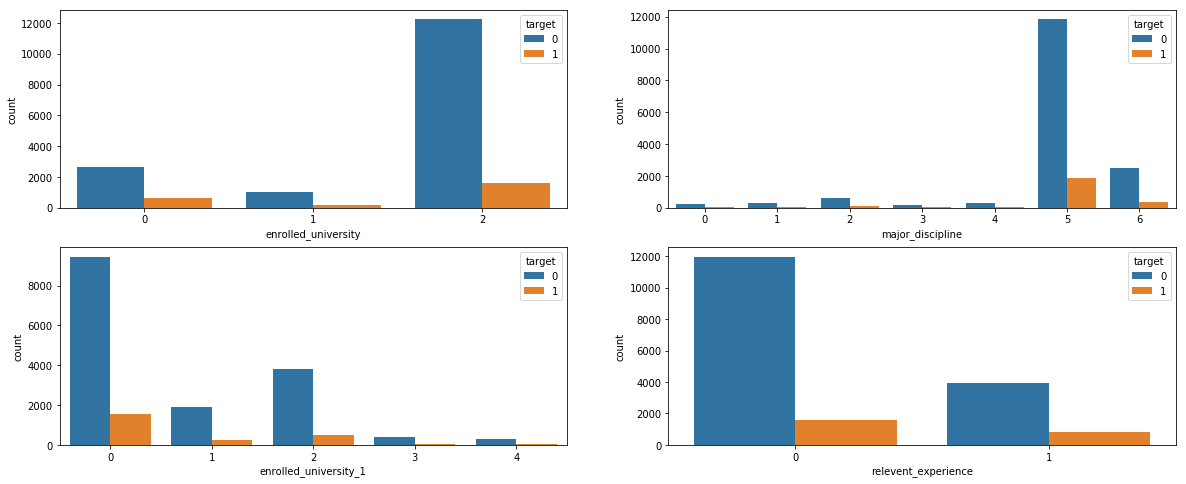

In [347]:
fig, ax = plt.subplots(nrows = 2,ncols = 2)
# sns.countplot('city_development_index',hue = 'target', data = train_set, ax = ax[0])
sns.countplot('enrolled_university',hue = 'target', data = x_train, ax = ax[0][0])
sns.countplot('enrolled_university_1',hue = 'target', data = x_train, ax = ax[1][0])
sns.countplot('major_discipline',hue = 'target', data = x_train, ax = ax[0][1])
sns.countplot('relevent_experience',hue = 'target', data = x_train, ax = ax[1][1])

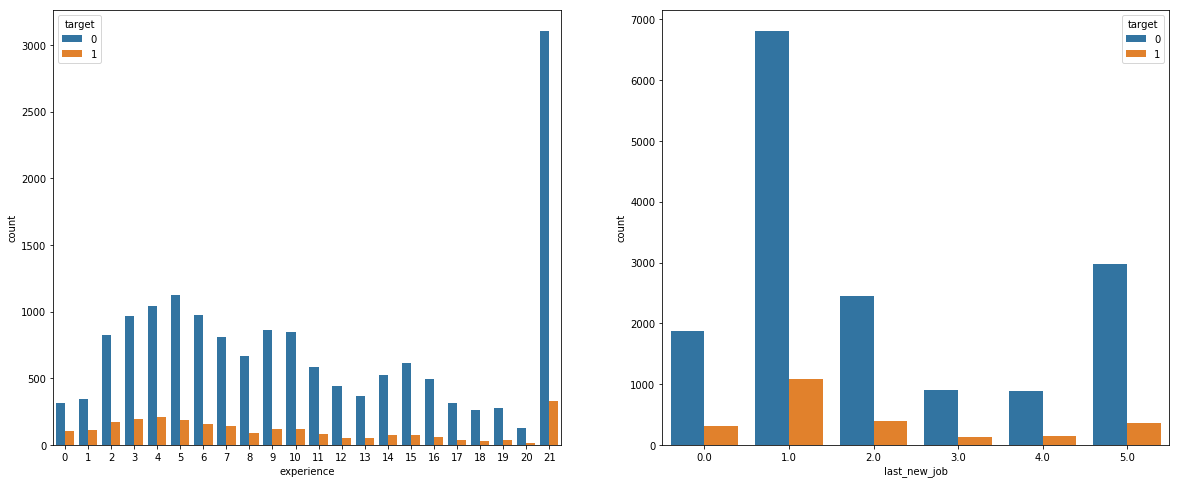

In [348]:
fig,ax = plt.subplots(ncols = 2)
sns.countplot('experience',hue = 'target', data = x_train,ax = ax[0])
sns.countplot('last_new_job', hue = 'target', data = x_train,ax = ax[1])

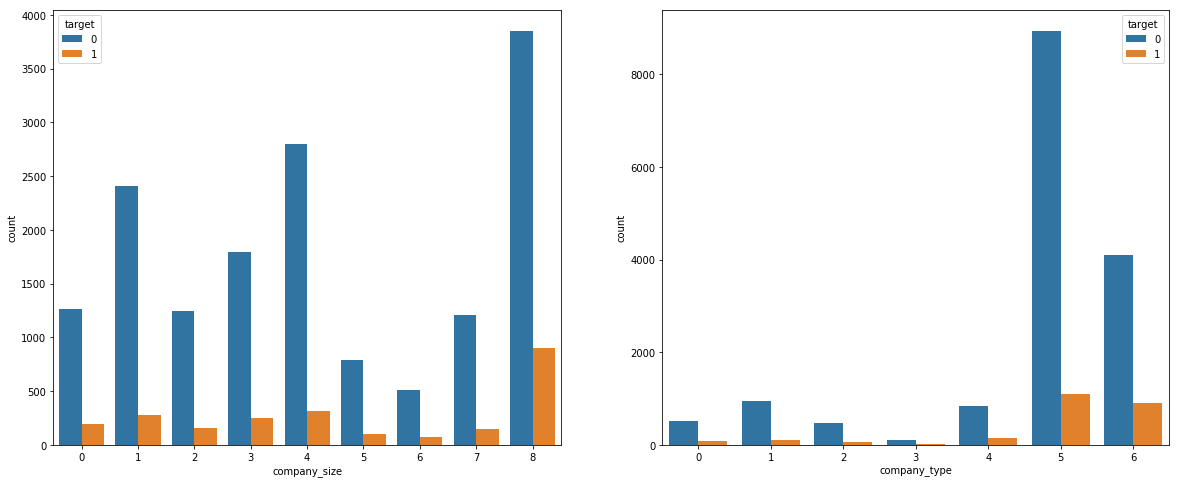

In [349]:
fig,ax = plt.subplots(ncols = 2)
sns.countplot('company_size',hue = 'target', data = x_train,ax = ax[0])
sns.countplot('company_type', hue = 'target', data = x_train,ax = ax[1])

## Encoding and decoding

In [170]:
x_temp = pd.DataFrame(x_temp)

In [171]:
x_temp = np.round(x_temp)

In [172]:
encoded_train = pd.concat([x_temp,pd.DataFrame(y_temp)],axis = 1)

In [173]:
encoded_train.columns = train_temp.drop(['enrollee_id'],1).columns

In [178]:
sm_2 = SMOTE(random_state = 42, kind = 'borderline2')

x_encoded_train,y_encoded_train = sm_2.fit_sample(x_temp,y_temp)

In [179]:
x_encoded_train = pd.DataFrame(x_encoded_train)
x_encoded_train = np.round(x_encoded_train)


In [180]:
encoded_train = pd.concat([x_encoded_train,pd.DataFrame(y_encoded_train)],axis = 1)

In [181]:
encoded_train.columns = train_temp.drop(['enrollee_id'],1).columns

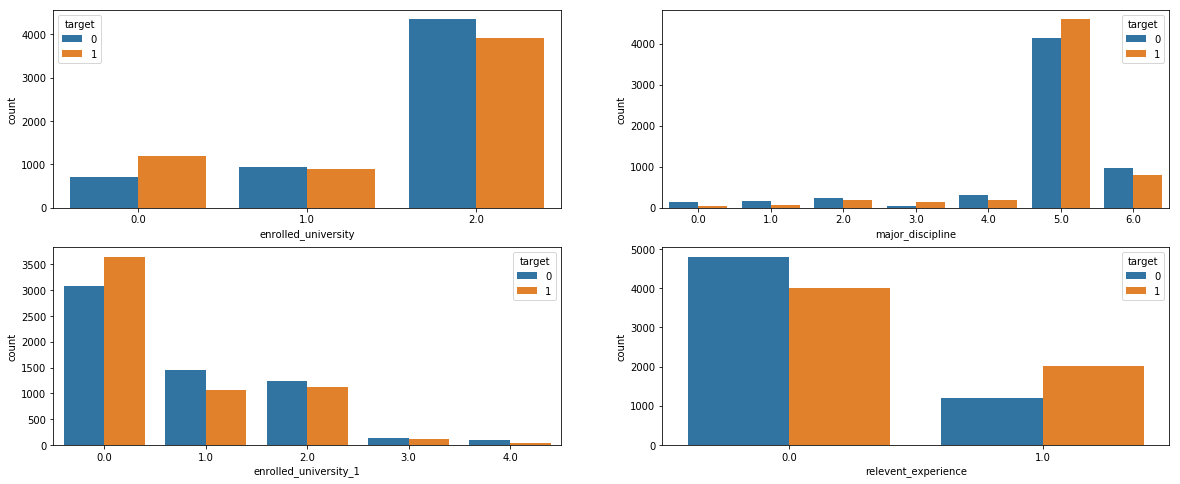

In [182]:
fig, ax = plt.subplots(nrows = 2,ncols = 2)
# sns.countplot('city_development_index',hue = 'target', data = train_set, ax = ax[0])
sns.countplot('enrolled_university',hue = 'target', data = encoded_train, ax = ax[0][0])
sns.countplot('enrolled_university_1',hue = 'target', data = encoded_train, ax = ax[1][0])
sns.countplot('major_discipline',hue = 'target', data = encoded_train, ax = ax[0][1])
sns.countplot('relevent_experience',hue = 'target', data = encoded_train, ax = ax[1][1])

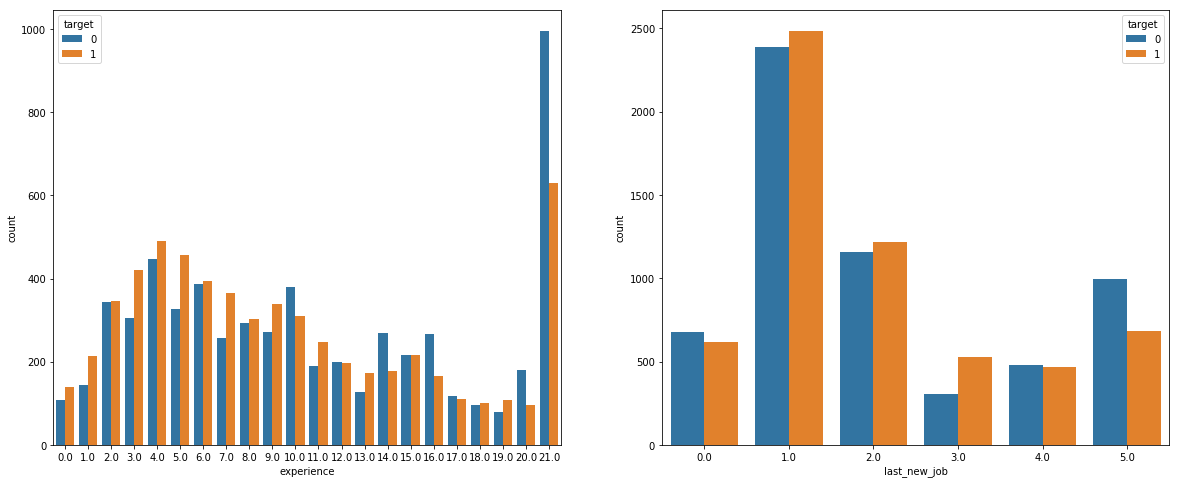

In [183]:
fig,ax = plt.subplots(ncols = 2)
sns.countplot('experience',hue = 'target', data = encoded_train,ax = ax[0])
sns.countplot('last_new_job', hue = 'target', data = encoded_train,ax = ax[1])

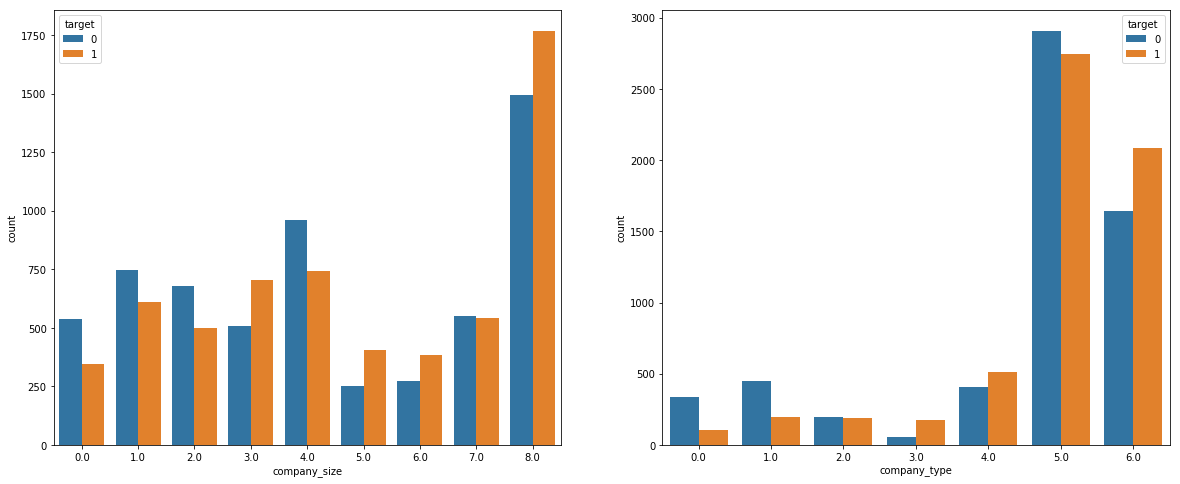

In [184]:
fig,ax = plt.subplots(ncols = 2)
sns.countplot('company_size',hue = 'target', data = encoded_train,ax = ax[0])
sns.countplot('company_type', hue = 'target', data = encoded_train,ax = ax[1])

In [185]:
x_train,x_test, y_train, y_test = train_test_split(encoded_train.drop('target',1),encoded_train.target,test_size = 0.2)

In [191]:
ctb = CBC(iterations = 2000, l2_leaf_reg= 5, learning_rate = 0.01,
    thread_count = 6,random_state= 42)
cat_feat = [0,2,3,4,5,6,8,9]
model = ctb.fit(encoded_train.drop('target',1),encoded_train.target)

0:	learn: 0.6920626	total: 19.5ms	remaining: 38.9s
1:	learn: 0.6911601	total: 38.6ms	remaining: 38.6s
2:	learn: 0.6902756	total: 57.6ms	remaining: 38.3s
3:	learn: 0.6893147	total: 77.1ms	remaining: 38.5s
4:	learn: 0.6884246	total: 94.8ms	remaining: 37.8s
5:	learn: 0.6874254	total: 113ms	remaining: 37.5s
6:	learn: 0.6865399	total: 131ms	remaining: 37.2s
7:	learn: 0.6855932	total: 148ms	remaining: 36.9s
8:	learn: 0.6846121	total: 166ms	remaining: 36.6s
9:	learn: 0.6837276	total: 184ms	remaining: 36.5s
10:	learn: 0.6829163	total: 201ms	remaining: 36.3s
11:	learn: 0.6820112	total: 222ms	remaining: 36.7s
12:	learn: 0.6811858	total: 245ms	remaining: 37.5s
13:	learn: 0.6803552	total: 264ms	remaining: 37.4s
14:	learn: 0.6795655	total: 282ms	remaining: 37.3s
15:	learn: 0.6787531	total: 299ms	remaining: 37.1s
16:	learn: 0.6781265	total: 318ms	remaining: 37.1s
17:	learn: 0.6773267	total: 337ms	remaining: 37.1s
18:	learn: 0.6766837	total: 355ms	remaining: 37s
19:	learn: 0.6759750	total: 374ms	rema

167:	learn: 0.6183483	total: 3.13s	remaining: 34.1s
168:	learn: 0.6180936	total: 3.15s	remaining: 34.1s
169:	learn: 0.6178535	total: 3.17s	remaining: 34.1s
170:	learn: 0.6176334	total: 3.18s	remaining: 34s
171:	learn: 0.6174463	total: 3.2s	remaining: 34s
172:	learn: 0.6172949	total: 3.22s	remaining: 34s
173:	learn: 0.6169826	total: 3.23s	remaining: 33.9s
174:	learn: 0.6167937	total: 3.25s	remaining: 33.9s
175:	learn: 0.6166107	total: 3.27s	remaining: 33.9s
176:	learn: 0.6164699	total: 3.29s	remaining: 33.9s
177:	learn: 0.6161687	total: 3.3s	remaining: 33.8s
178:	learn: 0.6159674	total: 3.32s	remaining: 33.8s
179:	learn: 0.6157299	total: 3.34s	remaining: 33.8s
180:	learn: 0.6155617	total: 3.36s	remaining: 33.8s
181:	learn: 0.6153093	total: 3.38s	remaining: 33.7s
182:	learn: 0.6151134	total: 3.4s	remaining: 33.7s
183:	learn: 0.6149975	total: 3.41s	remaining: 33.7s
184:	learn: 0.6147172	total: 3.43s	remaining: 33.6s
185:	learn: 0.6144452	total: 3.45s	remaining: 33.6s
186:	learn: 0.6142722

331:	learn: 0.5913352	total: 6.05s	remaining: 30.4s
332:	learn: 0.5911248	total: 6.07s	remaining: 30.4s
333:	learn: 0.5910103	total: 6.09s	remaining: 30.4s
334:	learn: 0.5908901	total: 6.11s	remaining: 30.4s
335:	learn: 0.5907538	total: 6.13s	remaining: 30.3s
336:	learn: 0.5905848	total: 6.14s	remaining: 30.3s
337:	learn: 0.5904534	total: 6.16s	remaining: 30.3s
338:	learn: 0.5903231	total: 6.18s	remaining: 30.3s
339:	learn: 0.5902071	total: 6.2s	remaining: 30.3s
340:	learn: 0.5900841	total: 6.22s	remaining: 30.3s
341:	learn: 0.5899796	total: 6.24s	remaining: 30.2s
342:	learn: 0.5898918	total: 6.26s	remaining: 30.2s
343:	learn: 0.5897656	total: 6.28s	remaining: 30.2s
344:	learn: 0.5896745	total: 6.3s	remaining: 30.2s
345:	learn: 0.5895240	total: 6.32s	remaining: 30.2s
346:	learn: 0.5894539	total: 6.34s	remaining: 30.2s
347:	learn: 0.5893444	total: 6.36s	remaining: 30.2s
348:	learn: 0.5892109	total: 6.38s	remaining: 30.2s
349:	learn: 0.5890518	total: 6.39s	remaining: 30.2s
350:	learn: 0.

499:	learn: 0.5733958	total: 9.19s	remaining: 27.6s
500:	learn: 0.5733045	total: 9.21s	remaining: 27.5s
501:	learn: 0.5731758	total: 9.22s	remaining: 27.5s
502:	learn: 0.5730927	total: 9.24s	remaining: 27.5s
503:	learn: 0.5730063	total: 9.26s	remaining: 27.5s
504:	learn: 0.5729023	total: 9.28s	remaining: 27.5s
505:	learn: 0.5728107	total: 9.29s	remaining: 27.4s
506:	learn: 0.5727207	total: 9.31s	remaining: 27.4s
507:	learn: 0.5726312	total: 9.33s	remaining: 27.4s
508:	learn: 0.5725891	total: 9.34s	remaining: 27.4s
509:	learn: 0.5724263	total: 9.36s	remaining: 27.3s
510:	learn: 0.5723188	total: 9.38s	remaining: 27.3s
511:	learn: 0.5722165	total: 9.4s	remaining: 27.3s
512:	learn: 0.5720896	total: 9.42s	remaining: 27.3s
513:	learn: 0.5720347	total: 9.43s	remaining: 27.3s
514:	learn: 0.5719253	total: 9.45s	remaining: 27.3s
515:	learn: 0.5718088	total: 9.47s	remaining: 27.2s
516:	learn: 0.5716395	total: 9.49s	remaining: 27.2s
517:	learn: 0.5715741	total: 9.5s	remaining: 27.2s
518:	learn: 0.

665:	learn: 0.5598826	total: 12.1s	remaining: 24.2s
666:	learn: 0.5598226	total: 12.1s	remaining: 24.2s
667:	learn: 0.5597253	total: 12.1s	remaining: 24.2s
668:	learn: 0.5596278	total: 12.2s	remaining: 24.2s
669:	learn: 0.5595899	total: 12.2s	remaining: 24.2s
670:	learn: 0.5595466	total: 12.2s	remaining: 24.1s
671:	learn: 0.5594949	total: 12.2s	remaining: 24.1s
672:	learn: 0.5594291	total: 12.2s	remaining: 24.1s
673:	learn: 0.5593380	total: 12.2s	remaining: 24.1s
674:	learn: 0.5592462	total: 12.3s	remaining: 24.1s
675:	learn: 0.5591932	total: 12.3s	remaining: 24.1s
676:	learn: 0.5590697	total: 12.3s	remaining: 24.1s
677:	learn: 0.5589647	total: 12.3s	remaining: 24.1s
678:	learn: 0.5588554	total: 12.4s	remaining: 24s
679:	learn: 0.5587718	total: 12.4s	remaining: 24s
680:	learn: 0.5587215	total: 12.4s	remaining: 24s
681:	learn: 0.5586542	total: 12.4s	remaining: 24s
682:	learn: 0.5585812	total: 12.4s	remaining: 24s
683:	learn: 0.5585795	total: 12.5s	remaining: 24s
684:	learn: 0.5584854	to

827:	learn: 0.5482797	total: 15.3s	remaining: 21.6s
828:	learn: 0.5482294	total: 15.3s	remaining: 21.6s
829:	learn: 0.5481316	total: 15.3s	remaining: 21.6s
830:	learn: 0.5480774	total: 15.3s	remaining: 21.5s
831:	learn: 0.5479870	total: 15.3s	remaining: 21.5s
832:	learn: 0.5479258	total: 15.3s	remaining: 21.5s
833:	learn: 0.5478723	total: 15.4s	remaining: 21.5s
834:	learn: 0.5478208	total: 15.4s	remaining: 21.5s
835:	learn: 0.5477588	total: 15.4s	remaining: 21.4s
836:	learn: 0.5477120	total: 15.4s	remaining: 21.4s
837:	learn: 0.5475891	total: 15.4s	remaining: 21.4s
838:	learn: 0.5475012	total: 15.4s	remaining: 21.4s
839:	learn: 0.5474252	total: 15.5s	remaining: 21.4s
840:	learn: 0.5473841	total: 15.5s	remaining: 21.3s
841:	learn: 0.5473320	total: 15.5s	remaining: 21.3s
842:	learn: 0.5472368	total: 15.5s	remaining: 21.3s
843:	learn: 0.5471067	total: 15.5s	remaining: 21.3s
844:	learn: 0.5470568	total: 15.6s	remaining: 21.3s
845:	learn: 0.5469458	total: 15.6s	remaining: 21.3s
846:	learn: 

989:	learn: 0.5376273	total: 18.4s	remaining: 18.7s
990:	learn: 0.5375443	total: 18.4s	remaining: 18.7s
991:	learn: 0.5374602	total: 18.4s	remaining: 18.7s
992:	learn: 0.5374099	total: 18.4s	remaining: 18.7s
993:	learn: 0.5373199	total: 18.5s	remaining: 18.7s
994:	learn: 0.5372385	total: 18.5s	remaining: 18.7s
995:	learn: 0.5371827	total: 18.5s	remaining: 18.7s
996:	learn: 0.5371100	total: 18.6s	remaining: 18.7s
997:	learn: 0.5370454	total: 18.6s	remaining: 18.7s
998:	learn: 0.5369966	total: 18.6s	remaining: 18.6s
999:	learn: 0.5369211	total: 18.7s	remaining: 18.7s
1000:	learn: 0.5368369	total: 18.7s	remaining: 18.7s
1001:	learn: 0.5367535	total: 18.7s	remaining: 18.7s
1002:	learn: 0.5366942	total: 18.8s	remaining: 18.6s
1003:	learn: 0.5366242	total: 18.8s	remaining: 18.6s
1004:	learn: 0.5365736	total: 18.8s	remaining: 18.6s
1005:	learn: 0.5365336	total: 18.8s	remaining: 18.6s
1006:	learn: 0.5365040	total: 18.9s	remaining: 18.6s
1007:	learn: 0.5364346	total: 18.9s	remaining: 18.6s
1008

1145:	learn: 0.5281901	total: 22.2s	remaining: 16.5s
1146:	learn: 0.5281341	total: 22.2s	remaining: 16.5s
1147:	learn: 0.5280587	total: 22.2s	remaining: 16.5s
1148:	learn: 0.5279975	total: 22.3s	remaining: 16.5s
1149:	learn: 0.5279146	total: 22.3s	remaining: 16.5s
1150:	learn: 0.5278602	total: 22.3s	remaining: 16.4s
1151:	learn: 0.5278105	total: 22.3s	remaining: 16.4s
1152:	learn: 0.5277590	total: 22.3s	remaining: 16.4s
1153:	learn: 0.5276954	total: 22.4s	remaining: 16.4s
1154:	learn: 0.5276497	total: 22.4s	remaining: 16.4s
1155:	learn: 0.5276123	total: 22.4s	remaining: 16.4s
1156:	learn: 0.5275539	total: 22.4s	remaining: 16.3s
1157:	learn: 0.5274989	total: 22.4s	remaining: 16.3s
1158:	learn: 0.5274576	total: 22.5s	remaining: 16.3s
1159:	learn: 0.5273829	total: 22.5s	remaining: 16.3s
1160:	learn: 0.5273421	total: 22.5s	remaining: 16.3s
1161:	learn: 0.5272949	total: 22.5s	remaining: 16.2s
1162:	learn: 0.5272214	total: 22.5s	remaining: 16.2s
1163:	learn: 0.5271789	total: 22.6s	remaining:

1309:	learn: 0.5191661	total: 25.5s	remaining: 13.4s
1310:	learn: 0.5190859	total: 25.5s	remaining: 13.4s
1311:	learn: 0.5190019	total: 25.6s	remaining: 13.4s
1312:	learn: 0.5189390	total: 25.6s	remaining: 13.4s
1313:	learn: 0.5188470	total: 25.6s	remaining: 13.4s
1314:	learn: 0.5188173	total: 25.6s	remaining: 13.3s
1315:	learn: 0.5187624	total: 25.6s	remaining: 13.3s
1316:	learn: 0.5187197	total: 25.7s	remaining: 13.3s
1317:	learn: 0.5186728	total: 25.7s	remaining: 13.3s
1318:	learn: 0.5186188	total: 25.7s	remaining: 13.3s
1319:	learn: 0.5185815	total: 25.7s	remaining: 13.3s
1320:	learn: 0.5185555	total: 25.8s	remaining: 13.2s
1321:	learn: 0.5184958	total: 25.8s	remaining: 13.2s
1322:	learn: 0.5184455	total: 25.8s	remaining: 13.2s
1323:	learn: 0.5183914	total: 25.8s	remaining: 13.2s
1324:	learn: 0.5183443	total: 25.8s	remaining: 13.2s
1325:	learn: 0.5182840	total: 25.9s	remaining: 13.1s
1326:	learn: 0.5182444	total: 25.9s	remaining: 13.1s
1327:	learn: 0.5182029	total: 25.9s	remaining:

1469:	learn: 0.5114812	total: 28.8s	remaining: 10.4s
1470:	learn: 0.5114497	total: 28.8s	remaining: 10.4s
1471:	learn: 0.5114040	total: 28.8s	remaining: 10.3s
1472:	learn: 0.5113662	total: 28.8s	remaining: 10.3s
1473:	learn: 0.5112928	total: 28.9s	remaining: 10.3s
1474:	learn: 0.5112675	total: 28.9s	remaining: 10.3s
1475:	learn: 0.5112150	total: 28.9s	remaining: 10.3s
1476:	learn: 0.5111590	total: 28.9s	remaining: 10.2s
1477:	learn: 0.5111053	total: 28.9s	remaining: 10.2s
1478:	learn: 0.5110655	total: 29s	remaining: 10.2s
1479:	learn: 0.5110365	total: 29s	remaining: 10.2s
1480:	learn: 0.5110085	total: 29s	remaining: 10.2s
1481:	learn: 0.5109565	total: 29s	remaining: 10.1s
1482:	learn: 0.5109236	total: 29s	remaining: 10.1s
1483:	learn: 0.5108941	total: 29.1s	remaining: 10.1s
1484:	learn: 0.5108289	total: 29.1s	remaining: 10.1s
1485:	learn: 0.5107844	total: 29.1s	remaining: 10.1s
1486:	learn: 0.5106781	total: 29.1s	remaining: 10s
1487:	learn: 0.5106213	total: 29.1s	remaining: 10s
1488:	l

1632:	learn: 0.5043772	total: 32.1s	remaining: 7.22s
1633:	learn: 0.5043340	total: 32.1s	remaining: 7.2s
1634:	learn: 0.5042885	total: 32.2s	remaining: 7.18s
1635:	learn: 0.5042535	total: 32.2s	remaining: 7.16s
1636:	learn: 0.5041910	total: 32.2s	remaining: 7.14s
1637:	learn: 0.5041634	total: 32.2s	remaining: 7.12s
1638:	learn: 0.5041043	total: 32.2s	remaining: 7.1s
1639:	learn: 0.5040563	total: 32.3s	remaining: 7.08s
1640:	learn: 0.5040190	total: 32.3s	remaining: 7.06s
1641:	learn: 0.5039885	total: 32.3s	remaining: 7.04s
1642:	learn: 0.5039351	total: 32.3s	remaining: 7.02s
1643:	learn: 0.5038859	total: 32.3s	remaining: 7s
1644:	learn: 0.5038600	total: 32.4s	remaining: 6.98s
1645:	learn: 0.5038198	total: 32.4s	remaining: 6.96s
1646:	learn: 0.5037898	total: 32.4s	remaining: 6.94s
1647:	learn: 0.5037520	total: 32.4s	remaining: 6.92s
1648:	learn: 0.5037310	total: 32.4s	remaining: 6.9s
1649:	learn: 0.5037031	total: 32.5s	remaining: 6.88s
1650:	learn: 0.5036726	total: 32.5s	remaining: 6.86s

1794:	learn: 0.4979459	total: 35.4s	remaining: 4.04s
1795:	learn: 0.4978800	total: 35.4s	remaining: 4.02s
1796:	learn: 0.4978454	total: 35.4s	remaining: 4s
1797:	learn: 0.4978112	total: 35.4s	remaining: 3.98s
1798:	learn: 0.4977782	total: 35.5s	remaining: 3.96s
1799:	learn: 0.4977366	total: 35.5s	remaining: 3.94s
1800:	learn: 0.4977074	total: 35.5s	remaining: 3.92s
1801:	learn: 0.4976653	total: 35.5s	remaining: 3.9s
1802:	learn: 0.4976256	total: 35.5s	remaining: 3.88s
1803:	learn: 0.4975878	total: 35.6s	remaining: 3.86s
1804:	learn: 0.4975360	total: 35.6s	remaining: 3.84s
1805:	learn: 0.4975111	total: 35.6s	remaining: 3.82s
1806:	learn: 0.4975108	total: 35.6s	remaining: 3.8s
1807:	learn: 0.4974821	total: 35.6s	remaining: 3.78s
1808:	learn: 0.4974542	total: 35.6s	remaining: 3.76s
1809:	learn: 0.4974151	total: 35.7s	remaining: 3.74s
1810:	learn: 0.4973833	total: 35.7s	remaining: 3.72s
1811:	learn: 0.4973506	total: 35.7s	remaining: 3.71s
1812:	learn: 0.4972983	total: 35.7s	remaining: 3.69

1955:	learn: 0.4920335	total: 38.7s	remaining: 870ms
1956:	learn: 0.4919940	total: 38.7s	remaining: 850ms
1957:	learn: 0.4919597	total: 38.7s	remaining: 830ms
1958:	learn: 0.4919325	total: 38.7s	remaining: 811ms
1959:	learn: 0.4919154	total: 38.7s	remaining: 791ms
1960:	learn: 0.4918631	total: 38.8s	remaining: 771ms
1961:	learn: 0.4918192	total: 38.8s	remaining: 751ms
1962:	learn: 0.4917745	total: 38.8s	remaining: 731ms
1963:	learn: 0.4917605	total: 38.8s	remaining: 712ms
1964:	learn: 0.4917196	total: 38.9s	remaining: 692ms
1965:	learn: 0.4916636	total: 38.9s	remaining: 672ms
1966:	learn: 0.4916268	total: 38.9s	remaining: 653ms
1967:	learn: 0.4915734	total: 38.9s	remaining: 633ms
1968:	learn: 0.4915375	total: 38.9s	remaining: 613ms
1969:	learn: 0.4914515	total: 39s	remaining: 593ms
1970:	learn: 0.4914051	total: 39s	remaining: 573ms
1971:	learn: 0.4913542	total: 39s	remaining: 554ms
1972:	learn: 0.4913224	total: 39s	remaining: 534ms
1973:	learn: 0.4912985	total: 39s	remaining: 514ms
197

In [189]:
y_preds = model.predict(x_test)

print(precision_score(y_test, y_preds),
recall_score(y_test,y_preds))

0.7339667458432304 0.7555012224938875


In [190]:
pd.value_counts(y_preds)

1.0    1263
0.0    1137
dtype: int64

In [192]:
x_test = test_temp.drop('enrollee_id',1)
x_test = convert(x_test,['city', 'gender', 'relevent_experience',
       'enrolled_university', 'enrolled_university_1', 'major_discipline',
        'company_size', 'company_type'])

In [193]:
y_preds = model.predict(x_test)

In [194]:
submission = pd.DataFrame()
submission['enrollee_id'] = test_temp.enrollee_id
submission['target'] = y_preds

submission.to_csv('./submission_supermacy.csv', index = False)

## Feature Engineering

In [440]:
train_temp.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,enrolled_university_1,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,city_dev_ind_range
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3.0,100-500,Pvt Ltd,1.0,106,0,"(0.673, 0.698]"
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14.0,<10,Funded Startup,1.0,69,0,"(0.899, 0.924]"
2,46,city_16,0.910,not null,Has relevent experience,no_enrollment,Graduate,STEM,6.0,50-99,Public Sector,2.0,4,0,"(0.899, 0.924]"
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14.0,50-99,Pvt Ltd,1.0,26,0,"(0.648, 0.673]"
4,21751,city_100,0.887,not null,No relevent experience,no_enrollment,Masters,STEM,8.0,not null,not null,2.0,88,1,"(0.874, 0.899]"


In [22]:
train_temp['city_dev_ind_range'] =pd.cut(train_temp.city_development_index,bins = 20)
test_temp['city_dev_ind_range'] =pd.cut(test_temp.city_development_index,bins = 20)

In [39]:
def new_city(df):
    city_pop = pd.DataFrame()
    city_pop['city'] = df.city.unique()
    city_pop['city_population'] = [len(df[df.city == i]) for i in df.city.unique()]
    city_pop['avg_experience'] = [np.median(df[df.city == i].experience) for i in df.city.unique()]
    city_pop['avg_training_hours'] = [np.median(df[df.city == i].training_hours) for i in df.city.unique()]
    
    df = df.merge(city_pop, on= 'city', how = 'inner')
    return df

In [40]:
train_temp_new = new_city(train_temp)
test_temp_new = new_city(test_temp)

In [80]:
pd.value_counts(train_temp_new.target)

0    15337
1     2317
Name: target, dtype: int64

In [218]:
x_train_1 = train_temp_new.drop(['enrollee_id','target'],1)
x_test = test_temp_new.drop(['enrollee_id'],1)
y_train_1 = train_temp_new.target

In [219]:
x_train_1 = convert(x_train_1,['city', 'gender', 'relevent_experience',
       'enrolled_university', 'enrolled_university_1', 'major_discipline',
        'company_size', 'company_type','city_dev_ind_range'])
x_test = convert(x_test,['city', 'gender', 'relevent_experience',
       'enrolled_university', 'enrolled_university_1', 'major_discipline',
        'company_size', 'company_type','city_dev_ind_range'])

In [220]:
train_x, valid_x, train_y, valid_y = train_test_split(x_train_1,y_train_1,test_size = 0.3) 

In [221]:
pd.value_counts(train_y)

0    10705
1     1652
Name: target, dtype: int64

In [222]:
sm = SMOTE(random_state = 42,kind='borderline2')

In [223]:
x_train,y_train = sm.fit_sample(train_x,train_y)
# x_train,y_train = sm.fit_sample(x_train,y_train)

In [224]:
x_train = np.round(x_train)

In [225]:
x_train = pd.DataFrame(x_train)

In [226]:
pd.value_counts(y_train)

1    10705
0    10705
dtype: int64

In [227]:
x_train.columns = train_temp_new.drop(['enrollee_id','target'],1).columns

In [213]:
xgm = xgbc(n_jobs = 6, random_state = 42)
model = xgm.fit(x_train,y_train)

In [214]:
# x_test.columns = ['city', 'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'enrolled_university_1', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours', 'city_dev_ind_range', 'city_population', 'avg_experience', 'avg_training_hours', 'city_has_Graduate_population', 'city_has_Masters_population', 'city_has_High School_population', 'city_has_Phd_population', 'city_has_Primary School_population']
y_preds = model.predict(valid_x)
# make_submission(test_temp.enrollee_id,y_preds,['enrollee_id','target'], name = 'submission_supermacy.csv')

C:\Users\aashi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [215]:
pd.value_counts(y_preds),pd.value_counts(valid_y)

(0    3944
 1    1353
 dtype: int64, 0    4593
 1     704
 Name: target, dtype: int64)

In [216]:
print(roc_auc_score(valid_y,y_preds))

0.5886081586604122


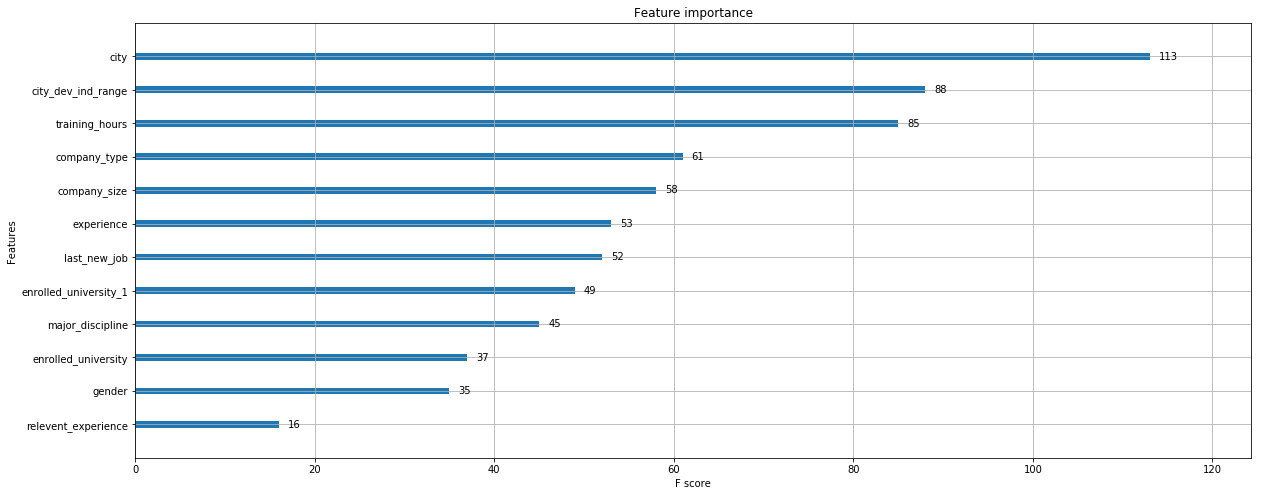

In [217]:
xgboost.plot_importance(model)

In [233]:
ctb = CBC(iterations = 2000,
          learning_rate = 0.01,
          depth = 6,
          thread_count = 6,
          random_state= 42)


model = ctb.fit(x_train,y_train)

0:	learn: 0.6913081	total: 48.8ms	remaining: 1m 37s
1:	learn: 0.6887366	total: 91.6ms	remaining: 1m 31s
2:	learn: 0.6866389	total: 137ms	remaining: 1m 31s
3:	learn: 0.6853727	total: 179ms	remaining: 1m 29s
4:	learn: 0.6833785	total: 226ms	remaining: 1m 30s
5:	learn: 0.6806718	total: 273ms	remaining: 1m 30s
6:	learn: 0.6780916	total: 313ms	remaining: 1m 29s
7:	learn: 0.6767161	total: 349ms	remaining: 1m 26s
8:	learn: 0.6752165	total: 395ms	remaining: 1m 27s
9:	learn: 0.6737544	total: 441ms	remaining: 1m 27s
10:	learn: 0.6723765	total: 487ms	remaining: 1m 28s
11:	learn: 0.6705091	total: 526ms	remaining: 1m 27s
12:	learn: 0.6685665	total: 571ms	remaining: 1m 27s
13:	learn: 0.6668066	total: 618ms	remaining: 1m 27s
14:	learn: 0.6645070	total: 665ms	remaining: 1m 27s
15:	learn: 0.6628455	total: 711ms	remaining: 1m 28s
16:	learn: 0.6608455	total: 763ms	remaining: 1m 29s
17:	learn: 0.6586112	total: 810ms	remaining: 1m 29s
18:	learn: 0.6573971	total: 854ms	remaining: 1m 29s
19:	learn: 0.6562535

161:	learn: 0.5387557	total: 6.77s	remaining: 1m 16s
162:	learn: 0.5381731	total: 6.81s	remaining: 1m 16s
163:	learn: 0.5377620	total: 6.85s	remaining: 1m 16s
164:	learn: 0.5375738	total: 6.89s	remaining: 1m 16s
165:	learn: 0.5372057	total: 6.92s	remaining: 1m 16s
166:	learn: 0.5366468	total: 6.95s	remaining: 1m 16s
167:	learn: 0.5362583	total: 6.99s	remaining: 1m 16s
168:	learn: 0.5358248	total: 7.02s	remaining: 1m 16s
169:	learn: 0.5356295	total: 7.06s	remaining: 1m 16s
170:	learn: 0.5353707	total: 7.11s	remaining: 1m 16s
171:	learn: 0.5348682	total: 7.16s	remaining: 1m 16s
172:	learn: 0.5345220	total: 7.2s	remaining: 1m 16s
173:	learn: 0.5340814	total: 7.25s	remaining: 1m 16s
174:	learn: 0.5338803	total: 7.29s	remaining: 1m 15s
175:	learn: 0.5335820	total: 7.33s	remaining: 1m 15s
176:	learn: 0.5333754	total: 7.37s	remaining: 1m 15s
177:	learn: 0.5331546	total: 7.4s	remaining: 1m 15s
178:	learn: 0.5322728	total: 7.43s	remaining: 1m 15s
179:	learn: 0.5320776	total: 7.46s	remaining: 1m

318:	learn: 0.4989085	total: 13.6s	remaining: 1m 11s
319:	learn: 0.4987056	total: 13.7s	remaining: 1m 11s
320:	learn: 0.4985963	total: 13.7s	remaining: 1m 11s
321:	learn: 0.4984080	total: 13.7s	remaining: 1m 11s
322:	learn: 0.4982764	total: 13.8s	remaining: 1m 11s
323:	learn: 0.4980814	total: 13.8s	remaining: 1m 11s
324:	learn: 0.4979227	total: 13.9s	remaining: 1m 11s
325:	learn: 0.4978075	total: 13.9s	remaining: 1m 11s
326:	learn: 0.4976215	total: 14s	remaining: 1m 11s
327:	learn: 0.4974446	total: 14s	remaining: 1m 11s
328:	learn: 0.4972436	total: 14s	remaining: 1m 11s
329:	learn: 0.4971169	total: 14.1s	remaining: 1m 11s
330:	learn: 0.4969753	total: 14.1s	remaining: 1m 11s
331:	learn: 0.4968208	total: 14.2s	remaining: 1m 11s
332:	learn: 0.4966050	total: 14.2s	remaining: 1m 11s
333:	learn: 0.4965149	total: 14.3s	remaining: 1m 11s
334:	learn: 0.4963889	total: 14.3s	remaining: 1m 11s
335:	learn: 0.4962372	total: 14.4s	remaining: 1m 11s
336:	learn: 0.4961380	total: 14.4s	remaining: 1m 11s

476:	learn: 0.4759563	total: 20.6s	remaining: 1m 5s
477:	learn: 0.4758350	total: 20.7s	remaining: 1m 5s
478:	learn: 0.4757623	total: 20.7s	remaining: 1m 5s
479:	learn: 0.4755627	total: 20.8s	remaining: 1m 5s
480:	learn: 0.4754938	total: 20.8s	remaining: 1m 5s
481:	learn: 0.4754159	total: 20.8s	remaining: 1m 5s
482:	learn: 0.4752844	total: 20.9s	remaining: 1m 5s
483:	learn: 0.4751347	total: 20.9s	remaining: 1m 5s
484:	learn: 0.4750356	total: 21s	remaining: 1m 5s
485:	learn: 0.4749292	total: 21s	remaining: 1m 5s
486:	learn: 0.4748371	total: 21.1s	remaining: 1m 5s
487:	learn: 0.4747684	total: 21.1s	remaining: 1m 5s
488:	learn: 0.4747031	total: 21.1s	remaining: 1m 5s
489:	learn: 0.4746298	total: 21.2s	remaining: 1m 5s
490:	learn: 0.4745740	total: 21.2s	remaining: 1m 5s
491:	learn: 0.4744511	total: 21.3s	remaining: 1m 5s
492:	learn: 0.4743966	total: 21.3s	remaining: 1m 5s
493:	learn: 0.4742998	total: 21.3s	remaining: 1m 5s
494:	learn: 0.4742129	total: 21.4s	remaining: 1m 5s
495:	learn: 0.47

636:	learn: 0.4578911	total: 27.6s	remaining: 59s
637:	learn: 0.4578252	total: 27.6s	remaining: 58.9s
638:	learn: 0.4577290	total: 27.6s	remaining: 58.9s
639:	learn: 0.4576135	total: 27.7s	remaining: 58.8s
640:	learn: 0.4575369	total: 27.7s	remaining: 58.7s
641:	learn: 0.4573844	total: 27.7s	remaining: 58.7s
642:	learn: 0.4573330	total: 27.8s	remaining: 58.6s
643:	learn: 0.4572200	total: 27.8s	remaining: 58.5s
644:	learn: 0.4570311	total: 27.8s	remaining: 58.5s
645:	learn: 0.4569070	total: 27.9s	remaining: 58.4s
646:	learn: 0.4567253	total: 27.9s	remaining: 58.3s
647:	learn: 0.4565944	total: 27.9s	remaining: 58.3s
648:	learn: 0.4565350	total: 28s	remaining: 58.2s
649:	learn: 0.4564272	total: 28s	remaining: 58.2s
650:	learn: 0.4563513	total: 28.1s	remaining: 58.2s
651:	learn: 0.4562871	total: 28.1s	remaining: 58.1s
652:	learn: 0.4561868	total: 28.2s	remaining: 58.1s
653:	learn: 0.4560784	total: 28.2s	remaining: 58.1s
654:	learn: 0.4559498	total: 28.3s	remaining: 58s
655:	learn: 0.455815

798:	learn: 0.4434971	total: 34.7s	remaining: 52.1s
799:	learn: 0.4434214	total: 34.7s	remaining: 52.1s
800:	learn: 0.4433643	total: 34.8s	remaining: 52s
801:	learn: 0.4433167	total: 34.8s	remaining: 52s
802:	learn: 0.4432533	total: 34.9s	remaining: 51.9s
803:	learn: 0.4432054	total: 34.9s	remaining: 51.9s
804:	learn: 0.4430954	total: 35s	remaining: 51.9s
805:	learn: 0.4430248	total: 35s	remaining: 51.9s
806:	learn: 0.4428669	total: 35.1s	remaining: 51.8s
807:	learn: 0.4427919	total: 35.1s	remaining: 51.8s
808:	learn: 0.4427218	total: 35.2s	remaining: 51.8s
809:	learn: 0.4426837	total: 35.2s	remaining: 51.7s
810:	learn: 0.4425867	total: 35.3s	remaining: 51.7s
811:	learn: 0.4425022	total: 35.3s	remaining: 51.6s
812:	learn: 0.4424432	total: 35.3s	remaining: 51.6s
813:	learn: 0.4423765	total: 35.4s	remaining: 51.5s
814:	learn: 0.4423171	total: 35.4s	remaining: 51.5s
815:	learn: 0.4422362	total: 35.5s	remaining: 51.5s
816:	learn: 0.4420841	total: 35.5s	remaining: 51.4s
817:	learn: 0.442021

958:	learn: 0.4318911	total: 42.2s	remaining: 45.8s
959:	learn: 0.4317983	total: 42.2s	remaining: 45.7s
960:	learn: 0.4317432	total: 42.2s	remaining: 45.7s
961:	learn: 0.4316725	total: 42.3s	remaining: 45.6s
962:	learn: 0.4316182	total: 42.3s	remaining: 45.6s
963:	learn: 0.4315241	total: 42.4s	remaining: 45.5s
964:	learn: 0.4314685	total: 42.4s	remaining: 45.5s
965:	learn: 0.4313886	total: 42.5s	remaining: 45.4s
966:	learn: 0.4312889	total: 42.5s	remaining: 45.4s
967:	learn: 0.4312250	total: 42.5s	remaining: 45.4s
968:	learn: 0.4311507	total: 42.6s	remaining: 45.3s
969:	learn: 0.4310465	total: 42.6s	remaining: 45.3s
970:	learn: 0.4309452	total: 42.7s	remaining: 45.2s
971:	learn: 0.4308443	total: 42.7s	remaining: 45.2s
972:	learn: 0.4307701	total: 42.8s	remaining: 45.2s
973:	learn: 0.4307026	total: 42.8s	remaining: 45.1s
974:	learn: 0.4306286	total: 42.9s	remaining: 45.1s
975:	learn: 0.4305589	total: 42.9s	remaining: 45s
976:	learn: 0.4304764	total: 42.9s	remaining: 45s
977:	learn: 0.43

1119:	learn: 0.4209119	total: 49.1s	remaining: 38.6s
1120:	learn: 0.4208060	total: 49.2s	remaining: 38.6s
1121:	learn: 0.4207425	total: 49.2s	remaining: 38.5s
1122:	learn: 0.4207085	total: 49.3s	remaining: 38.5s
1123:	learn: 0.4206451	total: 49.3s	remaining: 38.4s
1124:	learn: 0.4205514	total: 49.3s	remaining: 38.4s
1125:	learn: 0.4204840	total: 49.4s	remaining: 38.3s
1126:	learn: 0.4204266	total: 49.4s	remaining: 38.3s
1127:	learn: 0.4203778	total: 49.4s	remaining: 38.2s
1128:	learn: 0.4203376	total: 49.5s	remaining: 38.2s
1129:	learn: 0.4202868	total: 49.5s	remaining: 38.1s
1130:	learn: 0.4202088	total: 49.6s	remaining: 38.1s
1131:	learn: 0.4201555	total: 49.6s	remaining: 38s
1132:	learn: 0.4200927	total: 49.6s	remaining: 38s
1133:	learn: 0.4199661	total: 49.7s	remaining: 37.9s
1134:	learn: 0.4199126	total: 49.7s	remaining: 37.9s
1135:	learn: 0.4198321	total: 49.8s	remaining: 37.9s
1136:	learn: 0.4197639	total: 49.8s	remaining: 37.8s
1137:	learn: 0.4196381	total: 49.9s	remaining: 37.

1276:	learn: 0.4114587	total: 55.9s	remaining: 31.6s
1277:	learn: 0.4114082	total: 55.9s	remaining: 31.6s
1278:	learn: 0.4113536	total: 56s	remaining: 31.6s
1279:	learn: 0.4113185	total: 56s	remaining: 31.5s
1280:	learn: 0.4112858	total: 56.1s	remaining: 31.5s
1281:	learn: 0.4112470	total: 56.1s	remaining: 31.4s
1282:	learn: 0.4111784	total: 56.1s	remaining: 31.4s
1283:	learn: 0.4111364	total: 56.2s	remaining: 31.3s
1284:	learn: 0.4110180	total: 56.2s	remaining: 31.3s
1285:	learn: 0.4109287	total: 56.3s	remaining: 31.2s
1286:	learn: 0.4108771	total: 56.3s	remaining: 31.2s
1287:	learn: 0.4108128	total: 56.4s	remaining: 31.2s
1288:	learn: 0.4107911	total: 56.4s	remaining: 31.1s
1289:	learn: 0.4107432	total: 56.4s	remaining: 31.1s
1290:	learn: 0.4106856	total: 56.5s	remaining: 31s
1291:	learn: 0.4106386	total: 56.5s	remaining: 31s
1292:	learn: 0.4105924	total: 56.6s	remaining: 30.9s
1293:	learn: 0.4105031	total: 56.6s	remaining: 30.9s
1294:	learn: 0.4104293	total: 56.6s	remaining: 30.8s
1

1435:	learn: 0.4026918	total: 1m 2s	remaining: 24.5s
1436:	learn: 0.4026518	total: 1m 2s	remaining: 24.5s
1437:	learn: 0.4026080	total: 1m 2s	remaining: 24.4s
1438:	learn: 0.4025634	total: 1m 2s	remaining: 24.4s
1439:	learn: 0.4024870	total: 1m 2s	remaining: 24.3s
1440:	learn: 0.4024222	total: 1m 2s	remaining: 24.3s
1441:	learn: 0.4023884	total: 1m 2s	remaining: 24.3s
1442:	learn: 0.4023328	total: 1m 2s	remaining: 24.2s
1443:	learn: 0.4023135	total: 1m 2s	remaining: 24.2s
1444:	learn: 0.4022600	total: 1m 2s	remaining: 24.1s
1445:	learn: 0.4022052	total: 1m 2s	remaining: 24.1s
1446:	learn: 0.4021616	total: 1m 2s	remaining: 24s
1447:	learn: 0.4021361	total: 1m 2s	remaining: 24s
1448:	learn: 0.4020722	total: 1m 2s	remaining: 24s
1449:	learn: 0.4020192	total: 1m 3s	remaining: 23.9s
1450:	learn: 0.4019879	total: 1m 3s	remaining: 23.9s
1451:	learn: 0.4019345	total: 1m 3s	remaining: 23.8s
1452:	learn: 0.4018934	total: 1m 3s	remaining: 23.8s
1453:	learn: 0.4018231	total: 1m 3s	remaining: 23.7s

1592:	learn: 0.3950032	total: 1m 8s	remaining: 17.6s
1593:	learn: 0.3949601	total: 1m 8s	remaining: 17.6s
1594:	learn: 0.3949199	total: 1m 9s	remaining: 17.5s
1595:	learn: 0.3949084	total: 1m 9s	remaining: 17.5s
1596:	learn: 0.3948703	total: 1m 9s	remaining: 17.4s
1597:	learn: 0.3948448	total: 1m 9s	remaining: 17.4s
1598:	learn: 0.3947900	total: 1m 9s	remaining: 17.4s
1599:	learn: 0.3947585	total: 1m 9s	remaining: 17.3s
1600:	learn: 0.3947098	total: 1m 9s	remaining: 17.3s
1601:	learn: 0.3946512	total: 1m 9s	remaining: 17.2s
1602:	learn: 0.3946138	total: 1m 9s	remaining: 17.2s
1603:	learn: 0.3945882	total: 1m 9s	remaining: 17.1s
1604:	learn: 0.3945252	total: 1m 9s	remaining: 17.1s
1605:	learn: 0.3944712	total: 1m 9s	remaining: 17.1s
1606:	learn: 0.3944119	total: 1m 9s	remaining: 17s
1607:	learn: 0.3943454	total: 1m 9s	remaining: 17s
1608:	learn: 0.3942936	total: 1m 9s	remaining: 16.9s
1609:	learn: 0.3942673	total: 1m 9s	remaining: 16.9s
1610:	learn: 0.3942120	total: 1m 9s	remaining: 16.

1745:	learn: 0.3881581	total: 1m 15s	remaining: 11s
1746:	learn: 0.3880952	total: 1m 15s	remaining: 10.9s
1747:	learn: 0.3880742	total: 1m 15s	remaining: 10.9s
1748:	learn: 0.3880468	total: 1m 15s	remaining: 10.8s
1749:	learn: 0.3880117	total: 1m 15s	remaining: 10.8s
1750:	learn: 0.3879743	total: 1m 15s	remaining: 10.8s
1751:	learn: 0.3879012	total: 1m 15s	remaining: 10.7s
1752:	learn: 0.3878753	total: 1m 15s	remaining: 10.7s
1753:	learn: 0.3878455	total: 1m 15s	remaining: 10.6s
1754:	learn: 0.3878203	total: 1m 15s	remaining: 10.6s
1755:	learn: 0.3877925	total: 1m 15s	remaining: 10.5s
1756:	learn: 0.3877308	total: 1m 15s	remaining: 10.5s
1757:	learn: 0.3877157	total: 1m 16s	remaining: 10.5s
1758:	learn: 0.3876720	total: 1m 16s	remaining: 10.4s
1759:	learn: 0.3876343	total: 1m 16s	remaining: 10.4s
1760:	learn: 0.3875854	total: 1m 16s	remaining: 10.3s
1761:	learn: 0.3875330	total: 1m 16s	remaining: 10.3s
1762:	learn: 0.3874884	total: 1m 16s	remaining: 10.2s
1763:	learn: 0.3874449	total: 

1902:	learn: 0.3818242	total: 1m 22s	remaining: 4.2s
1903:	learn: 0.3817996	total: 1m 22s	remaining: 4.15s
1904:	learn: 0.3817590	total: 1m 22s	remaining: 4.11s
1905:	learn: 0.3817366	total: 1m 22s	remaining: 4.07s
1906:	learn: 0.3816785	total: 1m 22s	remaining: 4.03s
1907:	learn: 0.3816514	total: 1m 22s	remaining: 3.98s
1908:	learn: 0.3816060	total: 1m 22s	remaining: 3.94s
1909:	learn: 0.3816060	total: 1m 22s	remaining: 3.89s
1910:	learn: 0.3815690	total: 1m 22s	remaining: 3.85s
1911:	learn: 0.3815375	total: 1m 22s	remaining: 3.81s
1912:	learn: 0.3815054	total: 1m 22s	remaining: 3.76s
1913:	learn: 0.3815024	total: 1m 22s	remaining: 3.72s
1914:	learn: 0.3814561	total: 1m 22s	remaining: 3.68s
1915:	learn: 0.3814260	total: 1m 22s	remaining: 3.63s
1916:	learn: 0.3813978	total: 1m 22s	remaining: 3.59s
1917:	learn: 0.3813484	total: 1m 22s	remaining: 3.55s
1918:	learn: 0.3813043	total: 1m 23s	remaining: 3.5s
1919:	learn: 0.3812561	total: 1m 23s	remaining: 3.46s
1920:	learn: 0.3812029	total: 

In [96]:
# params = [{'l2_leaf_reg':[5,25], 'learning_rate': [0.01,0.07,0.1,0.3,0.5],
#          'iterations':[500,1000,1500,2000]}]

# scores = ['precision','recall']

# for score in scores:
# #     print(score)
#     clf = GridSearchCV(CBC(thread_count=6,random_state=42), params, cv = 2,
#                       scoring = '%s_macro' % score)
    
#     clf.fit(x_train,y_train)
    
#     print('Best parameters found on the development set:\n')
#     print(clf.best_params_)
    
#     print('\nGrid scores on development set:\n')
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
    
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print('%0.3f (+/-%0.03f) for %r' 
#              % (mean, std *2, params))
    
#     print('\nDetailed classification report:\n')
#     print('The model is trained on the full development set.')
#     print('The scores are computed on the full evaluation set.\n')
    
#     y_true, y_pred = y_test, clf.predict(x_test)
#     print(classification_report(y_true, y_pred))
#     print('\n')
# # ctb = catboost.CatBoostClassifier(
# #                                  thread_count = 6,random_state= 42)
# # cat_feat = [0,2,3,4,5,6,8,9]
# # model = ctb.fit(x_train,y_train)


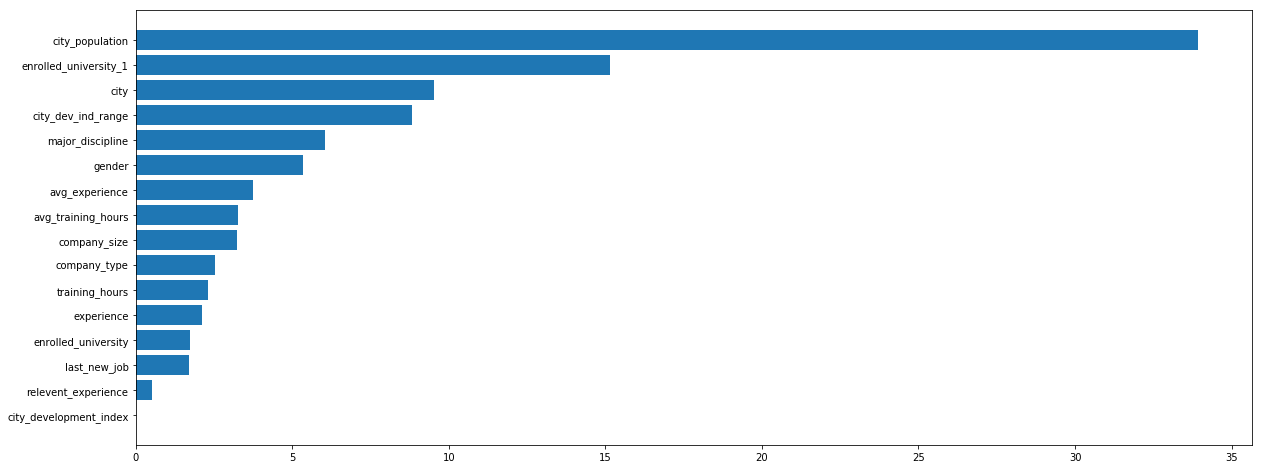

In [234]:
plot_imp_feat(train_temp_new.drop(['enrollee_id','target'],1).columns,ctb.feature_importances_)

In [235]:
y_preds = model.predict(valid_x)
print(roc_auc_score(valid_y, y_preds))
# print(classification_report(y_test,y_preds))

0.5736683028815562


In [236]:
pd.value_counts(y_preds)

0.0    4474
1.0     823
dtype: int64

In [103]:
make_submission(test_temp.enrollee_id,y_preds,['enrollee_id','target'], name = 'submission_supermacy.csv')


In [240]:
lr = LogisticRegression(max_iter=500,random_state=42)
model = lr.fit(x_train,y_train)

In [241]:
y_preds = model.predict(valid_x)
print(roc_auc_score(valid_y, y_preds))

0.6076655368992429


In [243]:
dt = DecisionTreeClassifier()
model = dt.fit(x_train,y_train)

In [244]:
y_preds = model.predict(valid_x)
print(roc_auc_score(valid_y, y_preds))

0.5165247964470762


In [ ]:
svmc = SVC()
model = svmc.fit(x_train,y_train)

In [ ]:
y_preds = model.predict(valid_x)
print(roc_auc_score(valid_y, y_preds))